# Разработка модели машинного обучения на основе данных HR-аналитики

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли.

У вас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**Цели работы:**

-изучить данные HR-аналитики

-проанализировать данные

-обучить модели машинного обучения при помощи пайплайна и подбора гиперпараметров под кросс-валидацией, провести feature engineering и тд

-добиться SMAPE ≤ 15 на тестовой выборке в задаче регресии и ROC-AUC ≥ 0.91 на тестовой выборке в задаче классификации

-предсказать уровень удовлетворённости сотрудника и уволиться ли сотрудник

**Описание данных:**

-в 1-ой задаче данные поделенны на 3 файла с тренировочной и тестовой выборкой: train_job_satisfaction_rate.csv, test_features.csv, test_target_job_satisfaction_rate.csv

Данные с признаками:

id — уникальный идентификатор сотрудника;

dept — отдел, в котором работает сотрудник;

level — уровень занимаемой должности;

workload — уровень загруженности сотрудника;

employment_years — длительность работы в компании (в годах);

last_year_promo — показывает, было ли повышение за последний год;

last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;

supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;

salary — ежемесячная зарплата сотрудника;

job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

-в 2-ой задаче данные поделенны на 3 файла с тренировочной и тестовой выборкой: train_quit.csv, test_features.csv, test_target_quit.csv

Те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании

**Краткий план работы:**

-провести предобработку данных: устранить пропуски, дубликаты

-исследовать данные: найти закономерности, зависимости, визуализировать результаты

-обучить при помощи пайплайна модель, провести feathers engineering, улучшить качество модели

-добиться качества целевой метрики согласно критерию успеха

# Задача 1: предсказание уровня удовлетворённости сотрудника

### Загрузка данных

In [ ]:
!pip install phik -q
!pip install shap -q
!pip install optuna -q
!pip install imbalanced-learn -q
!pip install catboost -q

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import phik
import shap
import scipy.stats as st
from optuna import distributions
from optuna.integration import OptunaSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, StandardScaler,
                                   MinMaxScaler, RobustScaler, PolynomialFeatures, LabelEncoder)
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, ElasticNet
from sklearn.metrics import (r2_score, mean_squared_error, accuracy_score, confusion_matrix,
                             recall_score, precision_score, mean_absolute_error, roc_auc_score, make_scorer)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE, SMOTENC
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings('ignore')

Данные представленны в 3 файлах, прочитаем их и сохраним

In [ ]:
df_train_rate = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv', sep = ',')
X_test_rate = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv', sep=',')
y_test_rate = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv', sep=',')

In [ ]:
df_train_rate.head()

id        dept   level workload  employment_years last_year_promo  \
0  155278       sales  junior   medium                 2              no   
1  653870          hr  junior     high                 2              no   
2  184592       sales  junior      low                 1              no   
3  171431  technology  junior      low                 4              no   
4  693419          hr  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      1   24000                   0.58  
1                   no                      5   38400                   0.76  
2                   no                      2   12000                   0.11  
3                   no                      2   18000                   0.37  
4                   no                      3   22800                   0.20

In [ ]:
df_train_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


В первой таблице 5 колонок типа object: dept, level, workload, last_year_promo, last_year_violations;

4 колонки типа int: id, employment_years, supervisor_evaluation, salary;

1 колонка типа float: job_satisfaction_rate

In [ ]:
X_test_rate.head()

id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800

In [ ]:
X_test_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Во второй таблице колонки идентичны 1-ой таблице за исключением целевого признака job_satisfaction_rate

In [ ]:
y_test_rate.head()

id  job_satisfaction_rate
0  130604                   0.74
1  825977                   0.75
2  418490                   0.60
3  555320                   0.72
4  826430                   0.08

In [ ]:
y_test_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


В третьей таблице колонка типа int (id) и целевой признак типа float: job_satisfaction_rate

### Предобработка данных

#### Пропуски и дубликаты

Проверим наличие пропусков в данных

In [ ]:
df_train_rate.isna().mean()

id                       0.0000
dept                     0.0015
level                    0.0010
workload                 0.0000
employment_years         0.0000
last_year_promo          0.0000
last_year_violations     0.0000
supervisor_evaluation    0.0000
salary                   0.0000
job_satisfaction_rate    0.0000
dtype: float64

In [ ]:
X_test_rate.isna().mean()

id                       0.0000
dept                     0.0010
level                    0.0005
workload                 0.0000
employment_years         0.0000
last_year_promo          0.0000
last_year_violations     0.0000
supervisor_evaluation    0.0000
salary                   0.0000
dtype: float64

In [ ]:
y_test_rate.isna().mean()

id                       0.0
job_satisfaction_rate    0.0
dtype: float64

Пропусков не обнаружено

Проверим дубликаты в данных

In [ ]:
df_train_rate.duplicated().sum()

0

In [ ]:
X_test_rate.duplicated().sum()

0

In [ ]:
y_test_rate.duplicated().sum()

0

Явных дубликатов нет

In [ ]:
X_test_rate.head()

id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800

In [ ]:
y_test_rate.head()

id  job_satisfaction_rate
0  130604                   0.74
1  825977                   0.75
2  418490                   0.60
3  555320                   0.72
4  826430                   0.08

In [ ]:
df_train_rate.head()

id        dept   level workload  employment_years last_year_promo  \
0  155278       sales  junior   medium                 2              no   
1  653870          hr  junior     high                 2              no   
2  184592       sales  junior      low                 1              no   
3  171431  technology  junior      low                 4              no   
4  693419          hr  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      1   24000                   0.58  
1                   no                      5   38400                   0.76  
2                   no                      2   12000                   0.11  
3                   no                      2   18000                   0.37  
4                   no                      3   22800                   0.20

In [ ]:
df_train_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [ ]:
X_test_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Типы данных в таблицах представленноы корректно

#### Неявные дубликаты

Проверим уникальные значения категориальных переменных

In [ ]:
df_train_rate['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

In [ ]:
df_train_rate['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

Значение 'sinior' явно носит грамматическую ошибку, исправим это

In [ ]:
df_train_rate['level'] = df_train_rate['level'].apply(lambda x: 'senior' if x == 'sinior'  else x)

In [ ]:
df_train_rate['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [ ]:
df_train_rate['workload'].unique()

array(['medium', 'high', 'low'], dtype=object)

In [ ]:
df_train_rate['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [ ]:
df_train_rate['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [ ]:
X_test_rate['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

Значение ' ' заменим на пропуск nan

In [ ]:
X_test_rate['dept'] = X_test_rate['dept'].apply(lambda x: np.nan if x == ' '  else x)

In [ ]:
X_test_rate['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

In [ ]:
X_test_rate['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

Грамматическая ошибка значения 'sinior'

In [ ]:
X_test_rate['level'] = X_test_rate['level'].apply(lambda x: 'senior' if x == 'sinior'  else x)

In [ ]:
X_test_rate['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [ ]:
X_test_rate['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

' ' заменим на nan

In [ ]:
X_test_rate['workload'] = X_test_rate['workload'].apply(lambda x: np.nan if x == ' '  else x)

In [ ]:
X_test_rate['workload'].unique()

array(['medium', 'low', 'high', nan], dtype=object)

In [ ]:
X_test_rate['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [ ]:
X_test_rate['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

Проверяем не появилось ли явных дубликатов

In [ ]:
X_test_rate.duplicated().sum()

0

#### Работа с порядком id

In [ ]:
pd.concat([y_test_rate['id'], X_test_rate['id']], axis=1).head()

id      id
0  130604  485046
1  825977  686555
2  418490  467458
3  555320  418655
4  826430  789145

Наблюдаем что порядок id у целевого признака тестовых данных не соответствует id входных признаков

Соберем входные и целевой признак в один фрейм отсортировав целевой признак по id

In [ ]:
df_test_rate = X_test_rate.merge(y_test_rate,on='id', how='inner')
df_test_rate.head()

id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      5   28800                   0.79  
1                   no                      4   30000                   0.72  
2                   no                      4   19200                   0.64  
3                   no                      4   19200                   0.60  
4                   no                      5   40800                   0.75

In [ ]:
y_test_rate[['id', 'job_satisfaction_rate']] = df_test_rate[['id', 'job_satisfaction_rate']]
y_test_rate

id  job_satisfaction_rate
0     485046                   0.79
1     686555                   0.72
2     467458                   0.64
3     418655                   0.60
4     789145                   0.75
...      ...                    ...
1995  393147                   0.56
1996  109582                   0.14
1997  305653                   0.11
1998  160233                   0.43
1999  771859                   0.67

[2000 rows x 2 columns]

In [ ]:
pd.concat([y_test_rate['id'], X_test_rate['id']], axis=1).head(10)

id      id
0  485046  485046
1  686555  686555
2  467458  467458
3  418655  418655
4  789145  789145
5  429973  429973
6  850699  850699
7  500791  500791
8  767867  767867
9  937235  937235

### Исследовательский анализ данных (train)

#### Категориальные признаки

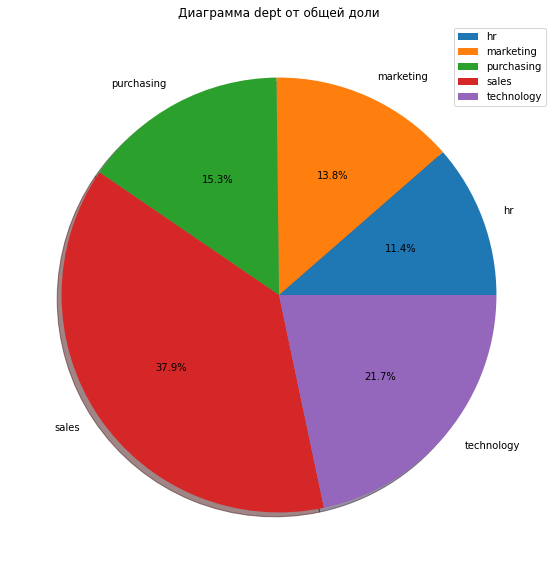

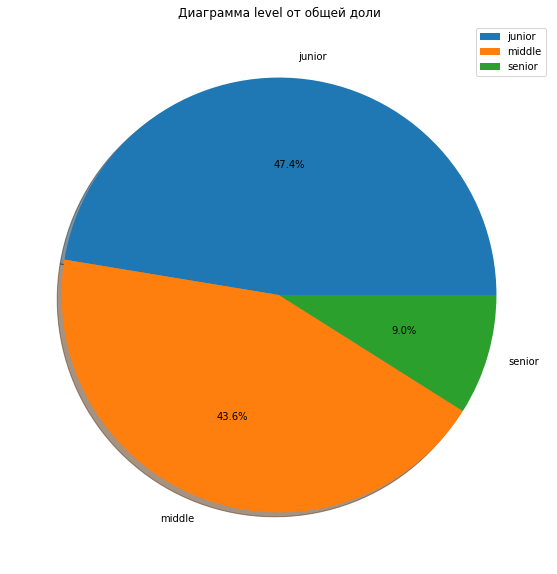

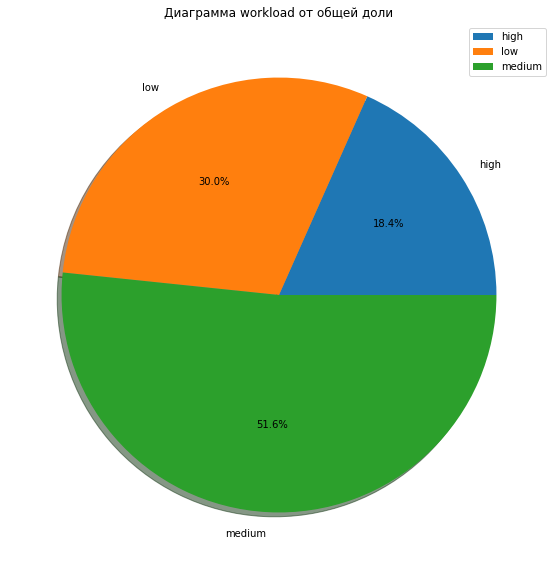

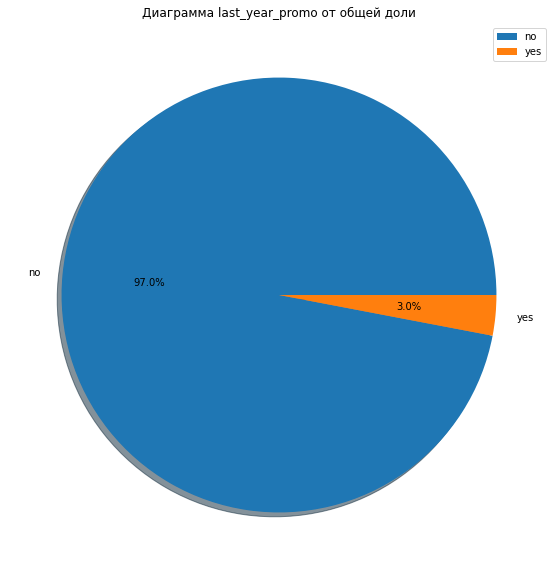

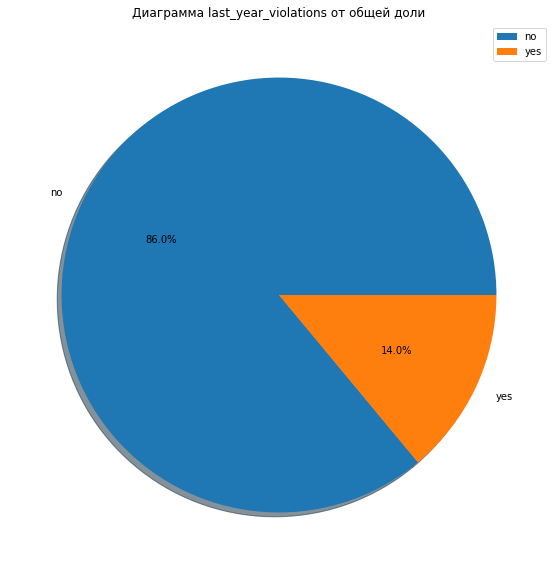

In [ ]:
for colum in ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']:
    fig, ax = plt.subplots(figsize=(12, 10))
    x = df_train_rate.groupby(colum)['id'].count()
    x = (x/len(df_train_rate) * 100).reset_index()
    labels = x[colum]
    x = x['id']
    plt.pie(x, labels=labels, autopct='%1.1f%%', shadow=True)
    plt.legend(loc="best")
    plt.title('Диаграмма '+ colum +' от общей доли')
    plt.show()

-Значения 'dept'( отдела, в котором работает сотрудник) делятся на 5 частей, чаще всего встречается отдел 'sales'(37.9%), по убыванию: 'technology'(21.7%), 'purchasing'(15.3%), 'marketing'(13.8%), hr(11.4%)

-Значения 'level'(уровень занимаемой должности) делятся на 3 частей, чаще всего встречается уровень 'junior'(47.4%), 'middle'(43.6%), реже всего встречается 'sinior'(9%)

-Значения 'workload'(уровень загруженности сотрудника) делятся на 3 частей, чаще всего встречается уровень 'medium'(51.6%), 'low'(30%), реже всего встречается 'high'(18.4%)

-Значения 'last_year_promo'(было ли повышение за последний год) делятся на 2 части, чаще всего встречается знаяение 'no'(97%), реже встречается 'yes'(3%)

-Значения 'last_year_violations'(нарушал ли сотрудник трудовой договор за последний год) делятся на 2 части, чаще всего встречается знаяение 'no'(86%), реже встречается 'yes'(14%)

#### Кол-ые признаки

Создадим функцию и выделим категории из целевого признака, для дальнейшей цветовой маркировки на гистограммах в целях визуализации закономерностей на кол-ых признаках

In [ ]:
def rate_cat(row):
    if row < 0.25:
        return 'low'
    elif row >= 0.25 and row < 0.5:
        return 'medium'
    elif row >= 0.5 and row < 0.75:
        return 'high'
    elif row > 0.75:
        return 'very high'
df_train_rate['rate_cat'] = df_train_rate['job_satisfaction_rate'].apply(rate_cat)
df_train_rate['rate_cat'].head()

0         high
1    very high
2          low
3       medium
4          low
Name: rate_cat, dtype: object

employment_years
count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


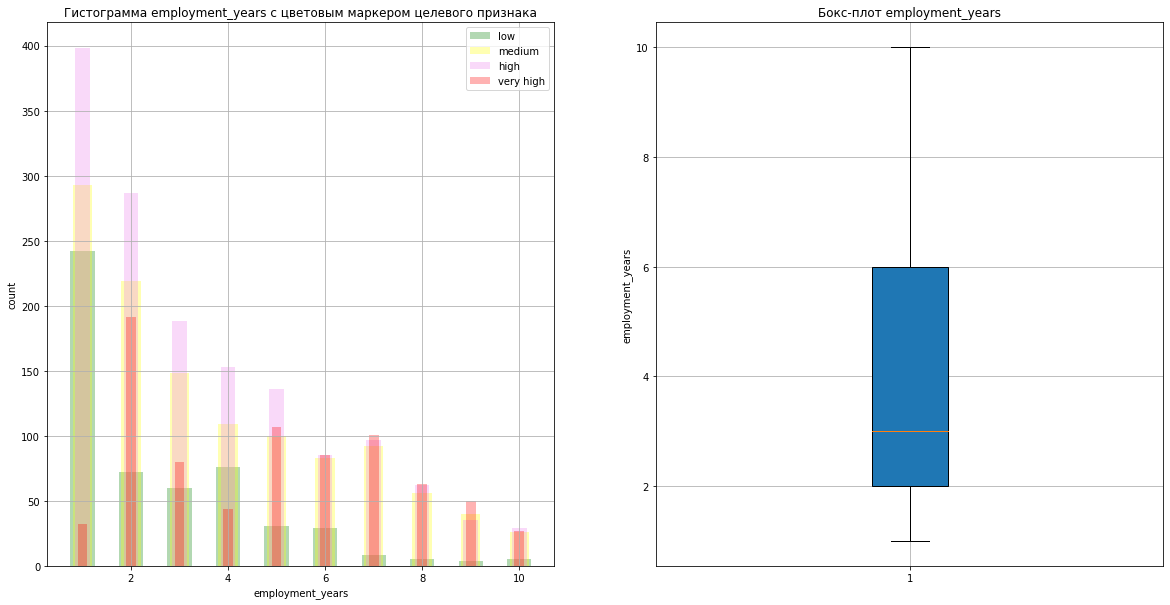

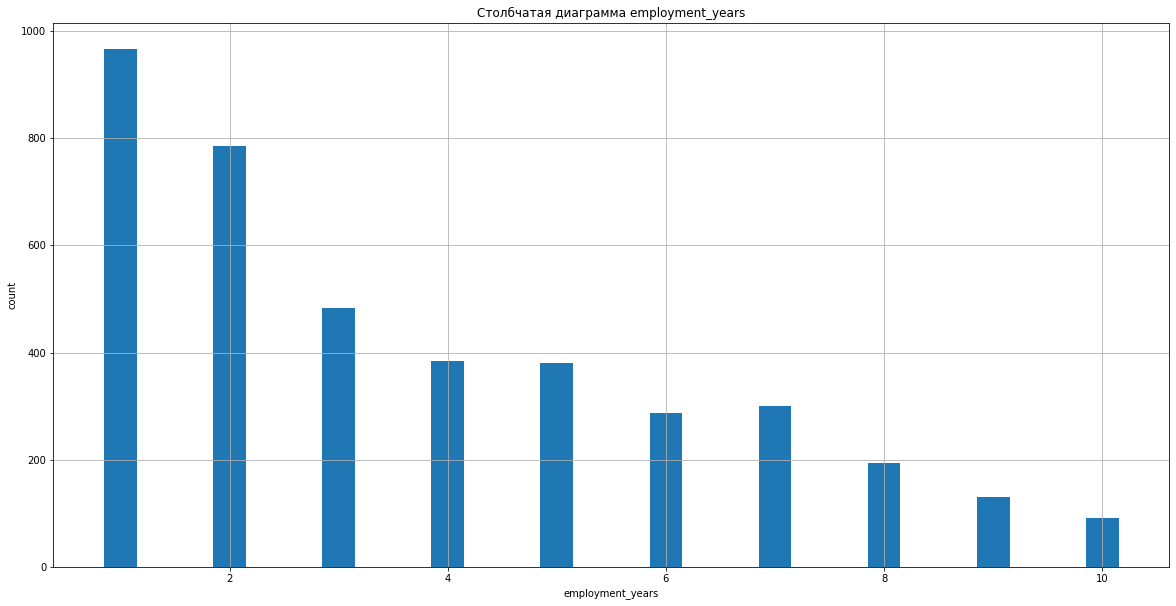

supervisor_evaluation
count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


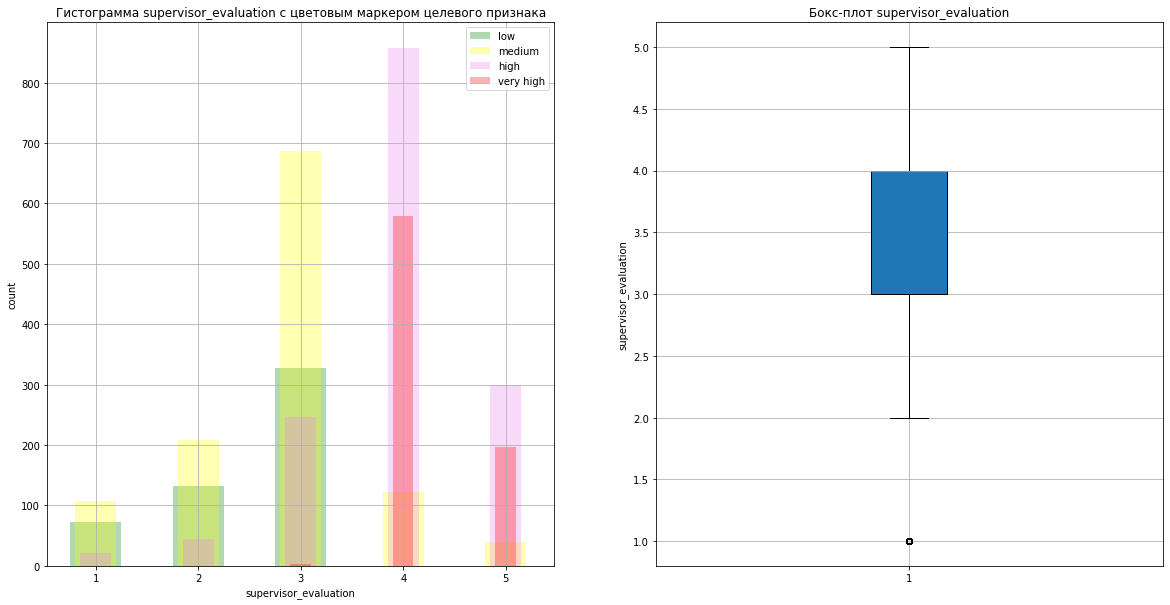

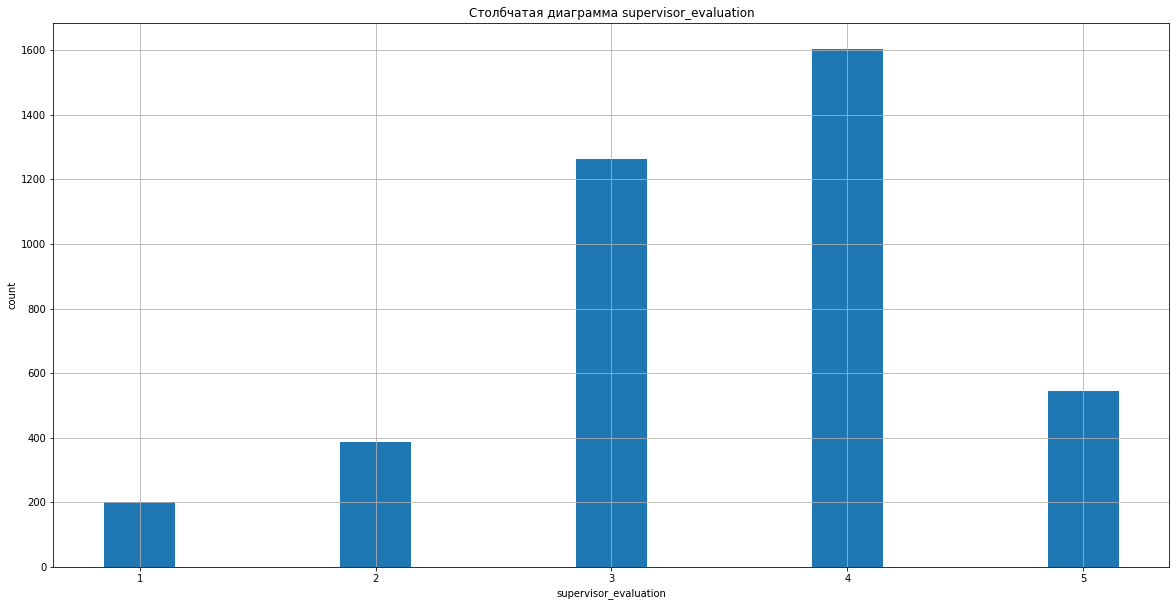

salary
count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64


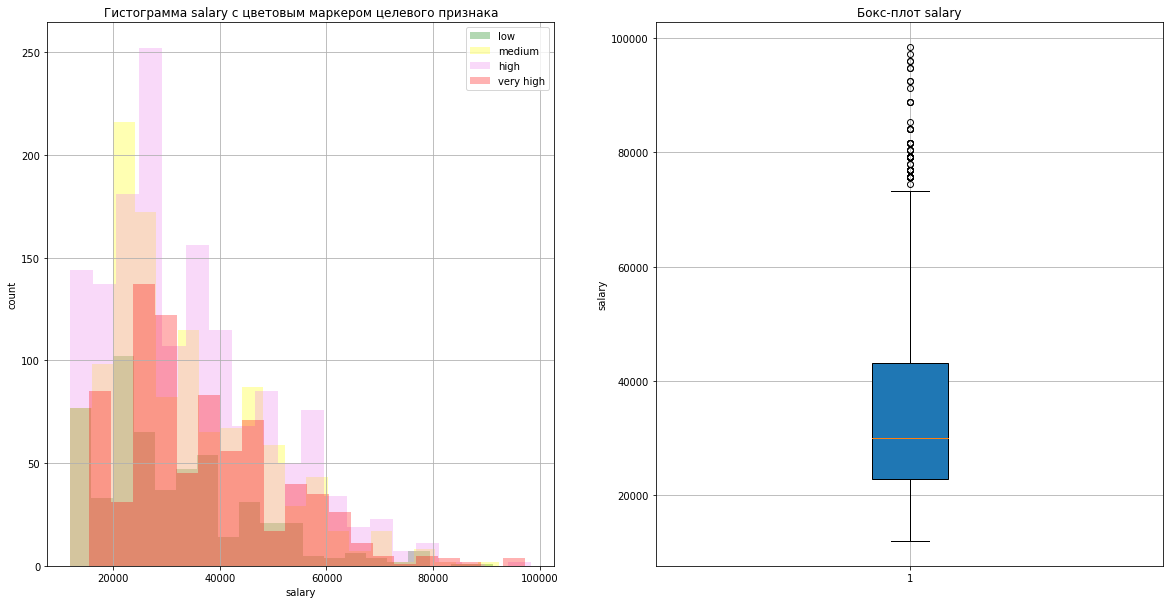

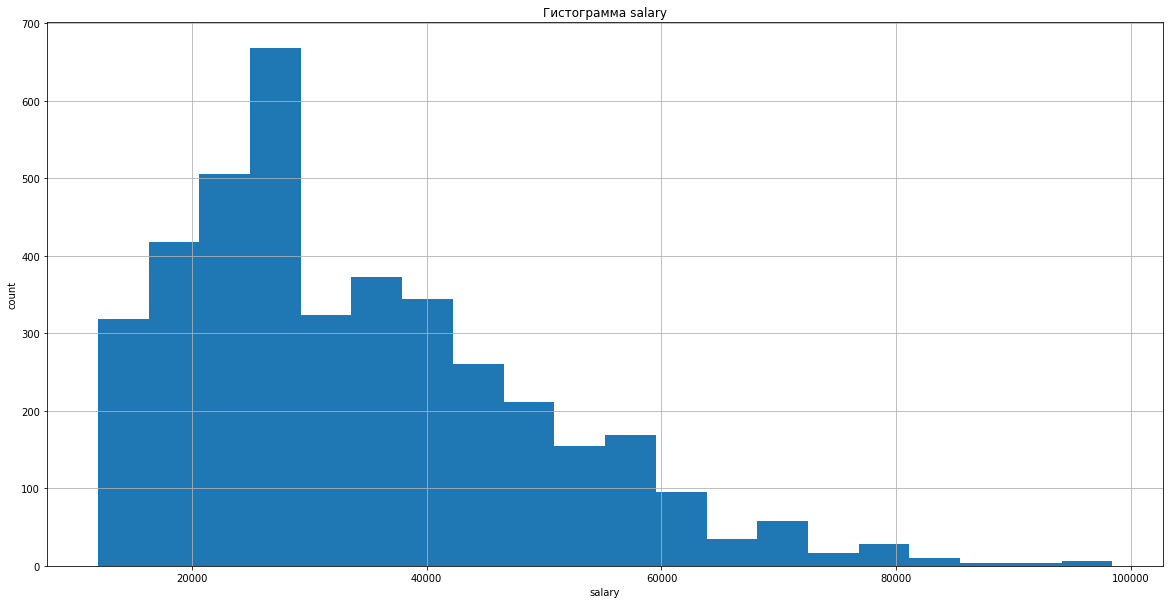

job_satisfaction_rate
count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


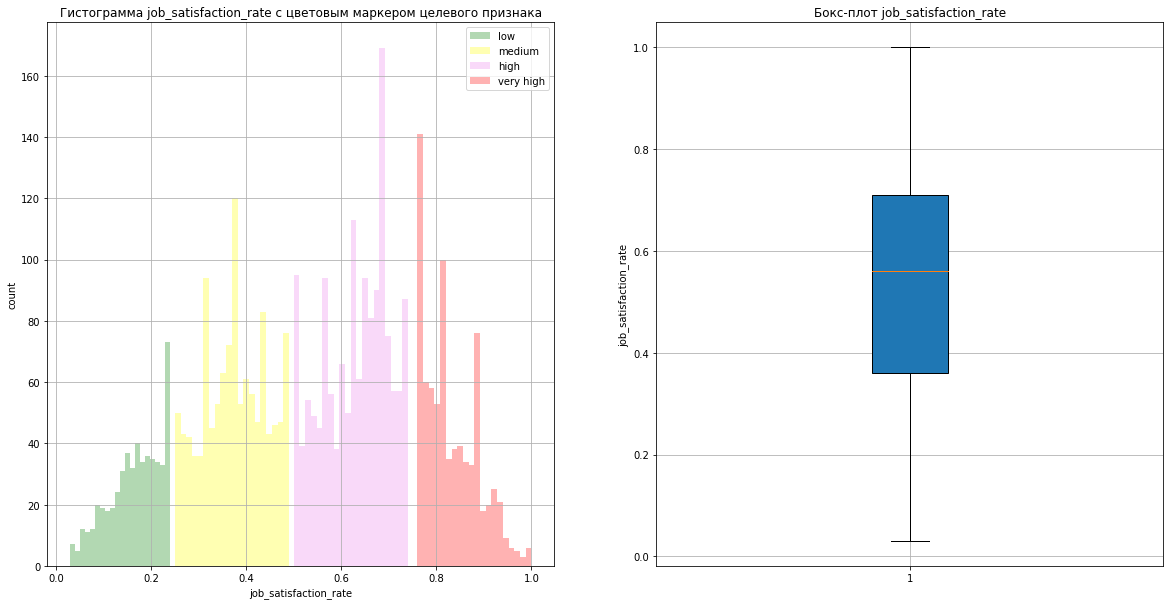

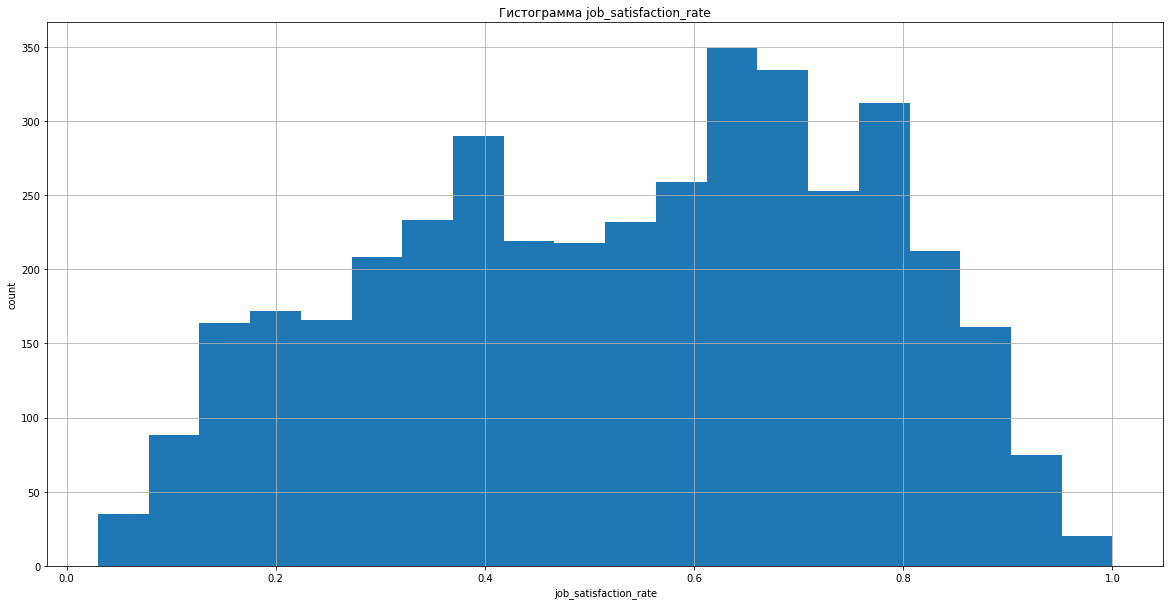

In [ ]:
for colum in ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']:
    print(colum)
    print(df_train_rate[colum].describe())
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    for color, row, leg, width in (['green', 'low', 'low', 0.5],
                            ['yellow', 'medium', 'medium', 0.4],
                            ['Violet', 'high', 'high', 0.3],
                            ['red', 'very high', 'very high', 0.2]):
        x = df_train_rate[df_train_rate['rate_cat'] == row][colum]
        if colum == 'salary' or colum == 'job_satisfaction_rate':
            ax[0].hist(x, bins=20, color=color, alpha=0.3, label=leg)
        else:
            y = list(df_train_rate[colum].unique())
            y.sort()
            x = []
            for i in y:
                l = df_train_rate[(df_train_rate['rate_cat'] == row
                                  ) & (df_train_rate[colum] ==i)][colum].count()
                x.append(l)
            ax[0].bar(y, x, alpha=0.3, color=color, width=width, label=leg)
    ax[0].set_xlabel(colum)
    ax[0].set_ylabel('count')
    ax[0].legend(loc="best")
    ax[0].set_title('Гистограмма ' + colum + ' с цветовым маркером целевого признака')
    ax[0].grid(True)

    ax[1].boxplot(df_train_rate[colum], patch_artist=True)
    ax[1].set_ylabel(colum)
    ax[1].set_title('Бокс-плот ' + colum)
    ax[1].grid(True)
    plt.show()

    fig, ax = plt.subplots(figsize=(20, 10))
    x = df_train_rate[colum]
    if colum == 'salary' or colum == 'job_satisfaction_rate':
        plt.hist(x, bins=20)
        plt.title('Гистограмма ' + colum)

    else:
        y = list(df_train_rate[colum].unique())
        y.sort()
        x = []
        for i in y:
            l = df_train_rate[df_train_rate[colum] ==i][colum].count()
            x.append(l)
        plt.bar(y, x, width=0.3)
        plt.title('Столбчатая диаграмма ' + colum)

    plt.xlabel(colum)
    plt.ylabel('count')
    plt.grid(True)
    plt.show()

-**'employment_years'**(длительность работы в компании) напоминает распределение Пуасона со 'скосом' к левому краю разброс длительности варьируется от 1 до 10 лет, в среднем 3.71

Цветовой маркер целевого признака указывает что уровень удовлетворённости сотрудника работой в компании меньше у людей которые меньше проработали

Аномальных значений не наблюдаем

-**'supervisor_evaluation'**(оценка качества работы сотрудника, которую дал руководитель) напоминает распределение Пуасона со 'скосом' к правому краю разброс оценки варьируется от 1 до 5, в среднем 3.47

Уровень удовлетворённости больше у сотрудников оцененных 4 или 5

'1' является слегка выбивающимся значением от общей массы

-**'salary'**(ежемесячная зарплата сотрудника) напоминает нормальное распределение со 'скосом' к левому краю разброс зарплаты варьируется от 12000 до 98400, в среднем 33926

Уровень удовлетворённости идентичный на почти всех уровнях зарплаты, только у слегка выбивающихся значений по правому краю уровень выше

Значения находящиеся в правой части распределения слегка выбиваются из общей массы

-**'job_satisfaction_rate'**(уровень удовлетворённости сотрудника работой в компании, целевой признак) напоминает нормальное распределение разброс уровня варьируется от 0.03 до 1, в среднем 0.53

Аномальных значений не наблюдаем

### Исследовательский анализ данных (test)

#### Категориальные признаки

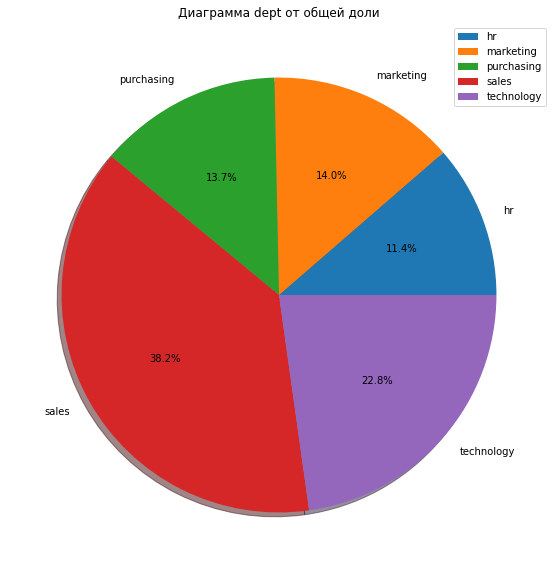

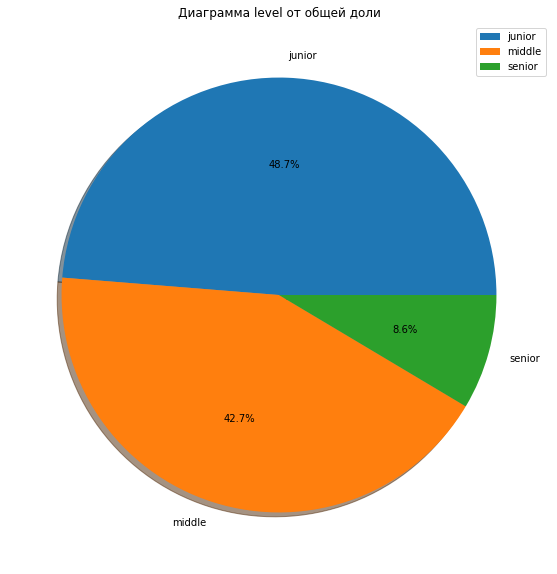

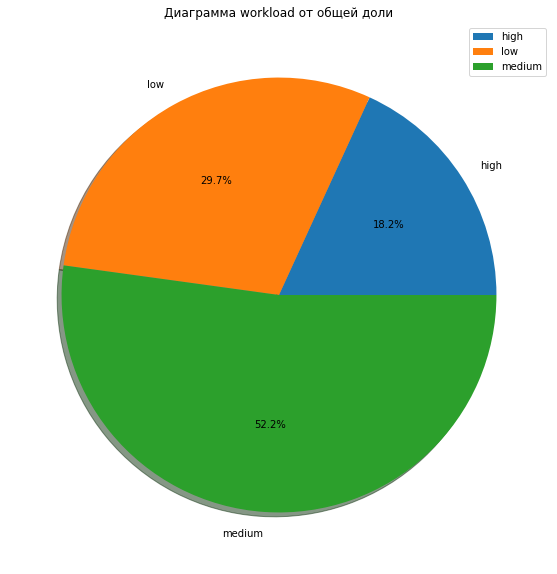

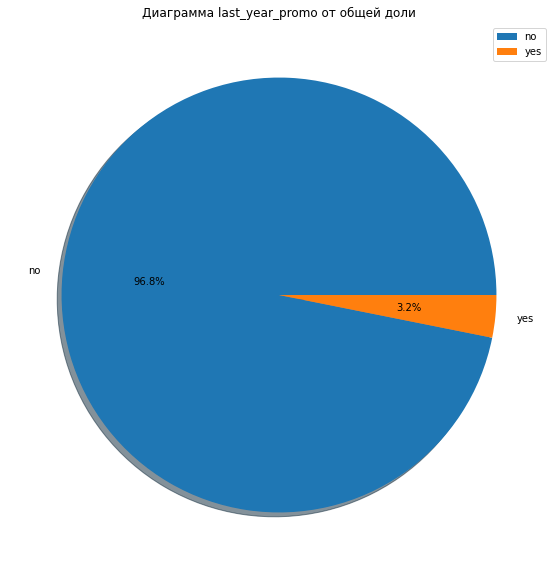

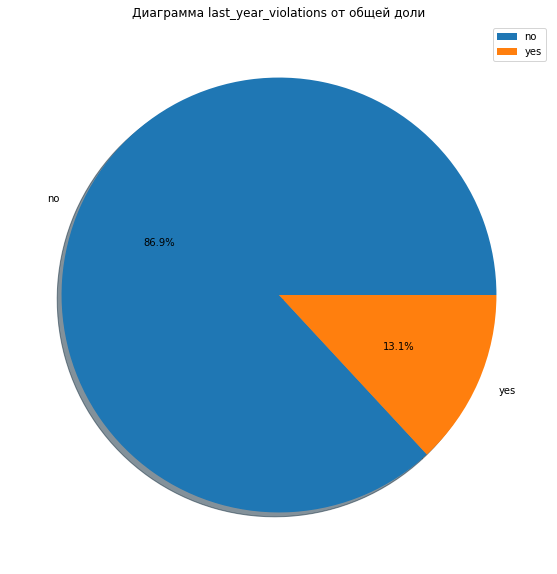

In [ ]:
for colum in ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']:
    fig, ax = plt.subplots(figsize=(12, 10))
    x = X_test_rate.groupby(colum)['id'].count()
    x = (x/len(X_test_rate) * 100).reset_index()
    labels = x[colum]
    x = x['id']
    plt.pie(x, labels=labels, autopct='%1.1f%%', shadow=True)
    plt.legend(loc="best")
    plt.title('Диаграмма '+ colum +' от общей доли')
    plt.show()

-Значения 'dept' на train( отдела, в котором работает сотрудник) делятся на 5 частей, чаще всего встречается отдел 'sales'(37.9%), по убыванию: 'technology'(21.7%), 'purchasing'(15.3%), 'marketing'(13.8%), hr(11.4%)

-Отличия на test: 'sales'(38.2%), 'technology'(22.8%), 'purchasing'(13.7%), 'marketing'(14%), hr-идентичная доля(11.4%)

-Значения 'level' на train(уровень занимаемой должности) делятся на 3 частей, чаще всего встречается уровень 'junior'(47.4%), 'middle'(43.6%), реже всего встречается 'sinior'(9%)

-Отличия на test: 'junior'(48.7%), 'middle'(42.7%), 'sinior'(8.6%)

-Значения 'workload' на train(уровень загруженности сотрудника) делятся на 3 частей, чаще всего встречается уровень 'medium'(51.6%), 'low'(30%), реже всего встречается 'high'(18.4%)

-Отличия на test: 'medium'(52.2%), 'low'(29.7%), 'high'(18.2%)

-Значения 'last_year_promo' на train(было ли повышение за последний год) делятся на 2 части, чаще всего встречается знаяение 'no'(97%), реже встречается 'yes'(3%)

-Отличия на test: 'no'(96.8%), 'yes'(3.2%)

-Значения 'last_year_violations' на train(нарушал ли сотрудник трудовой договор за последний год) делятся на 2 части, чаще всего встречается знаяение 'no'(86%), реже встречается 'yes'(14%)

-Отличия на test: 'no'(86.9%),  'yes'(13.1%)

#### Кол-ые признаки

In [ ]:
df_test_rate['rate_cat'] = df_test_rate['job_satisfaction_rate'].apply(rate_cat)
df_test_rate['rate_cat'].head()

0    very high
1         high
2         high
3         high
4         None
Name: rate_cat, dtype: object

employment_years
count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


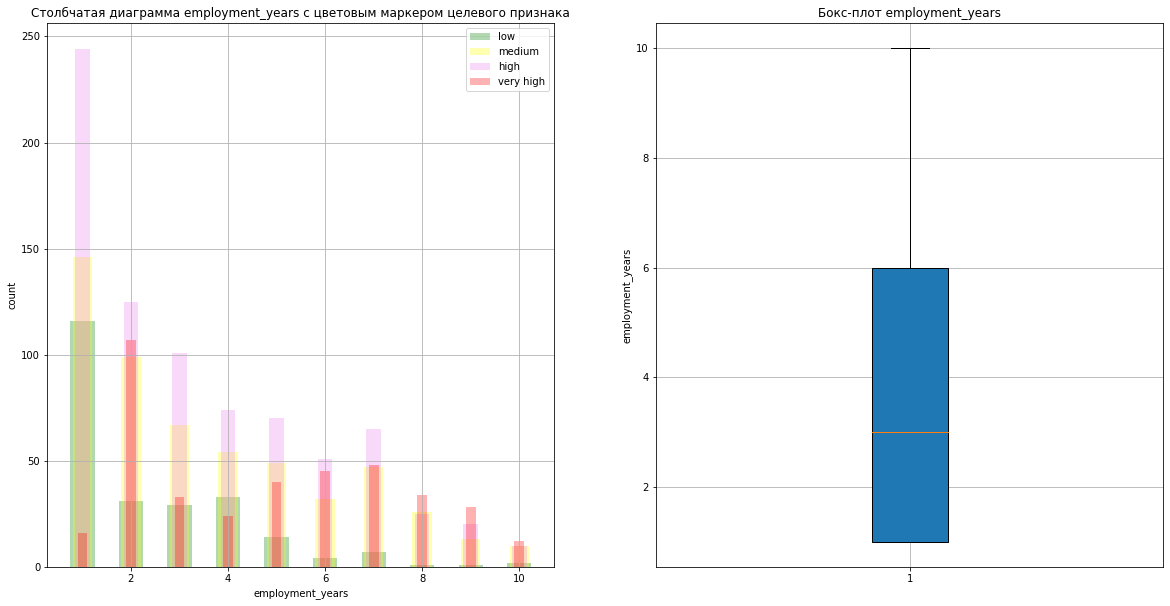

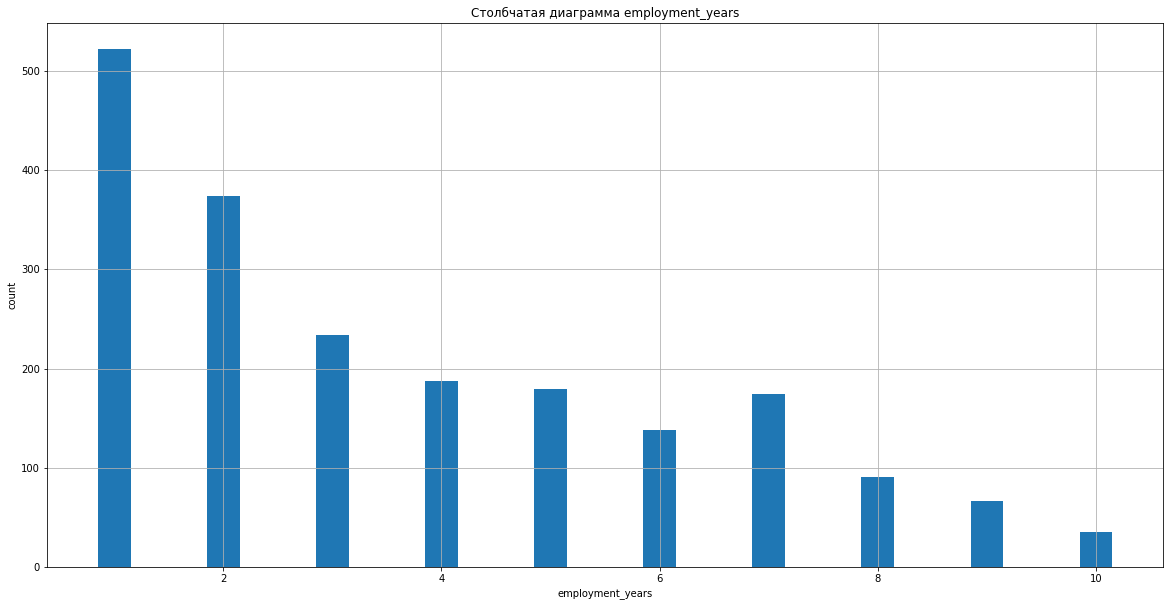

supervisor_evaluation
count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


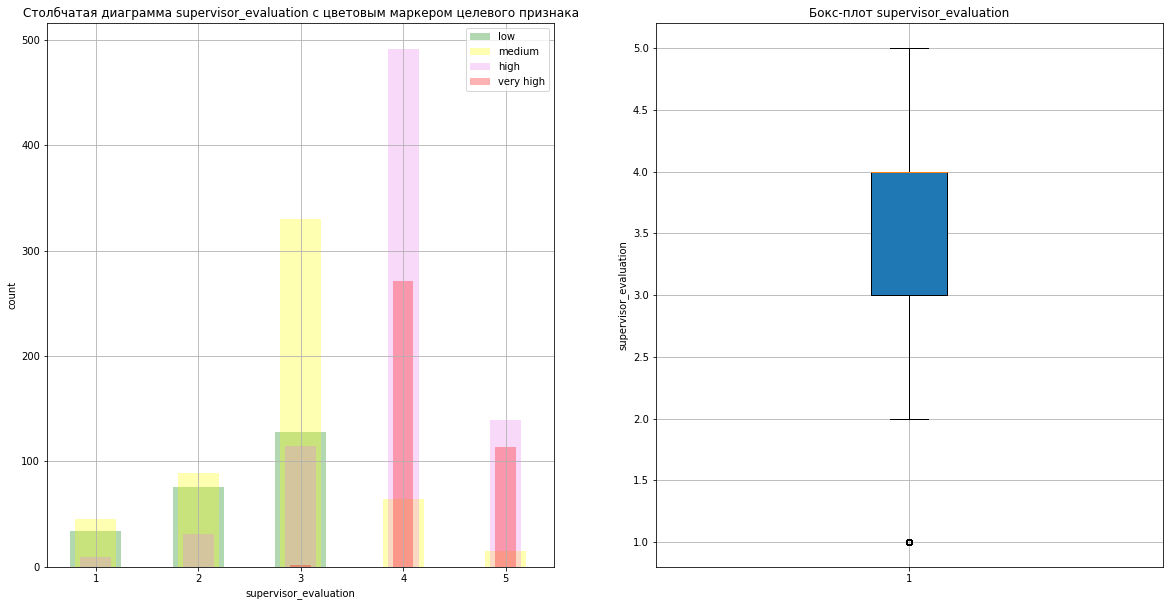

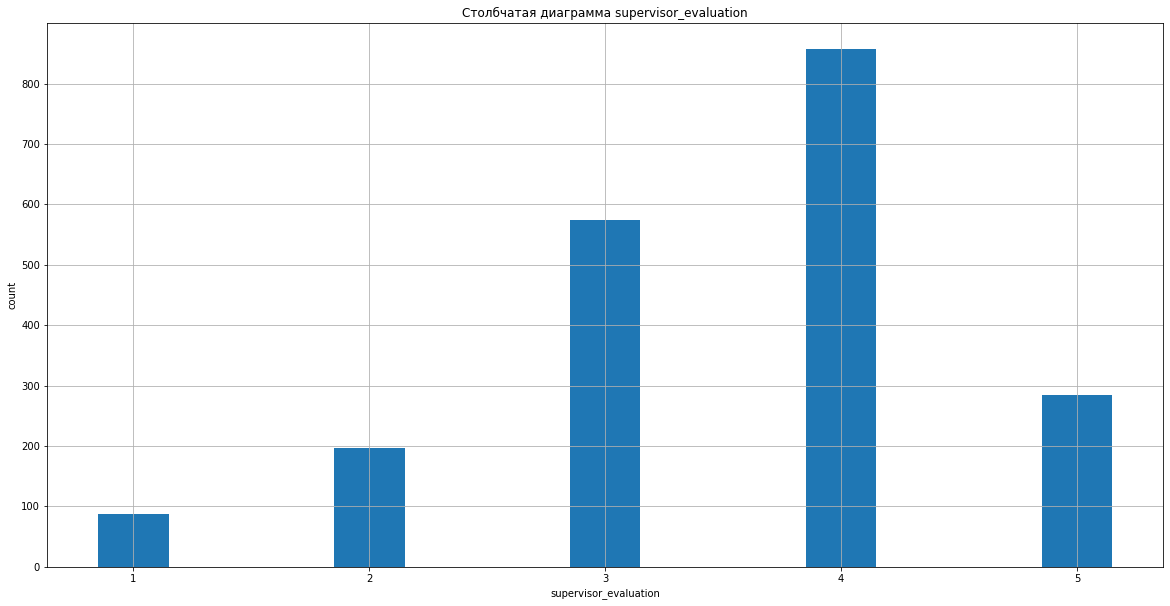

salary
count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


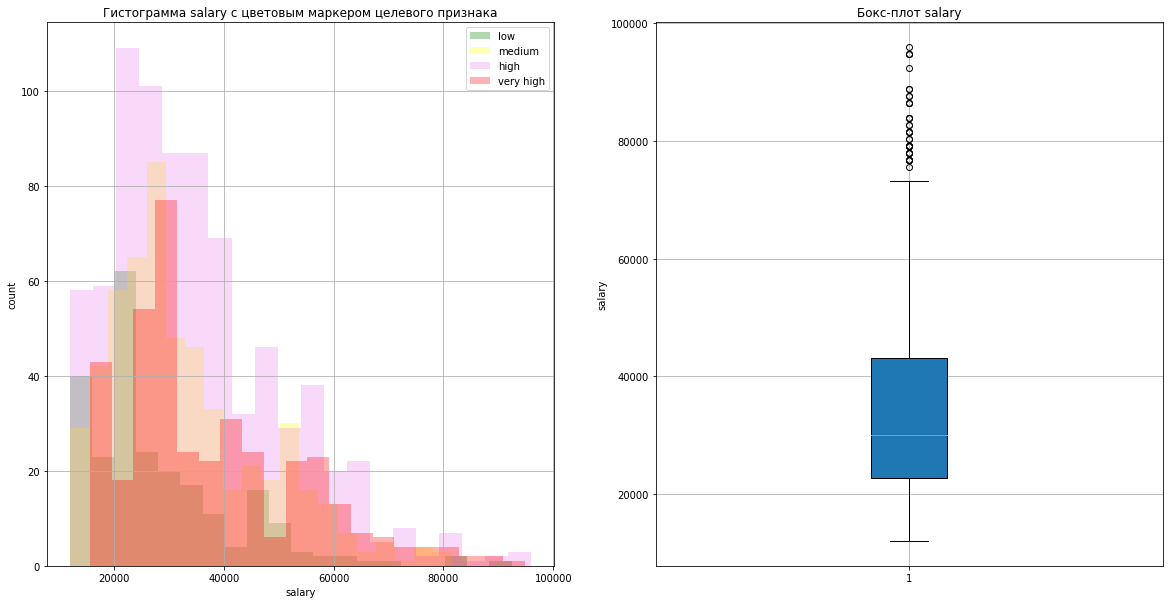

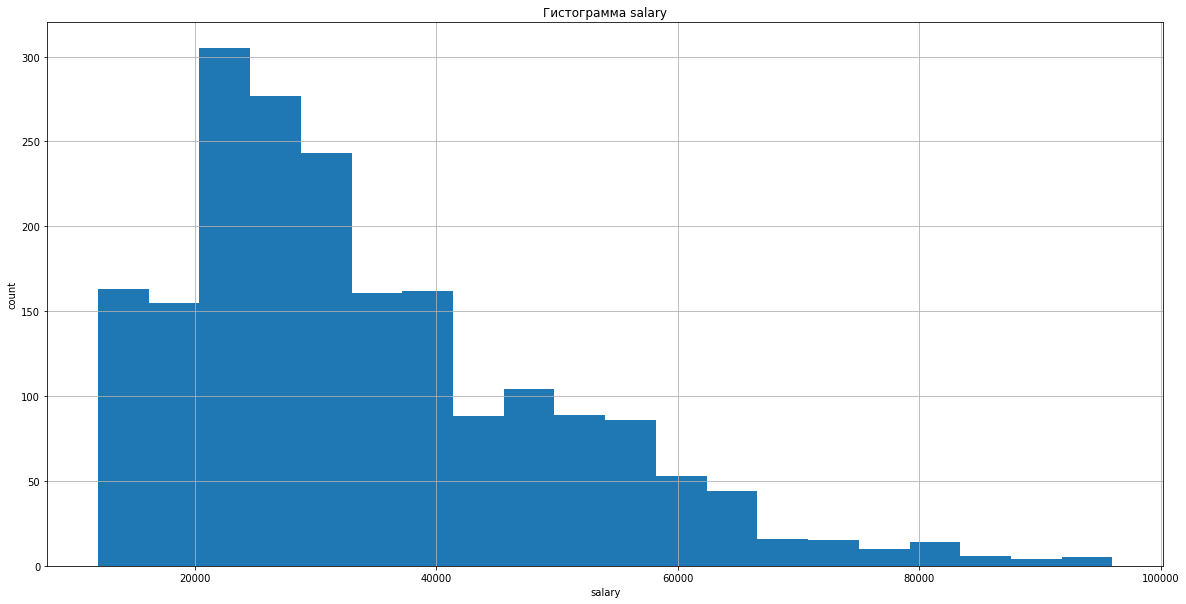

job_satisfaction_rate
count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64


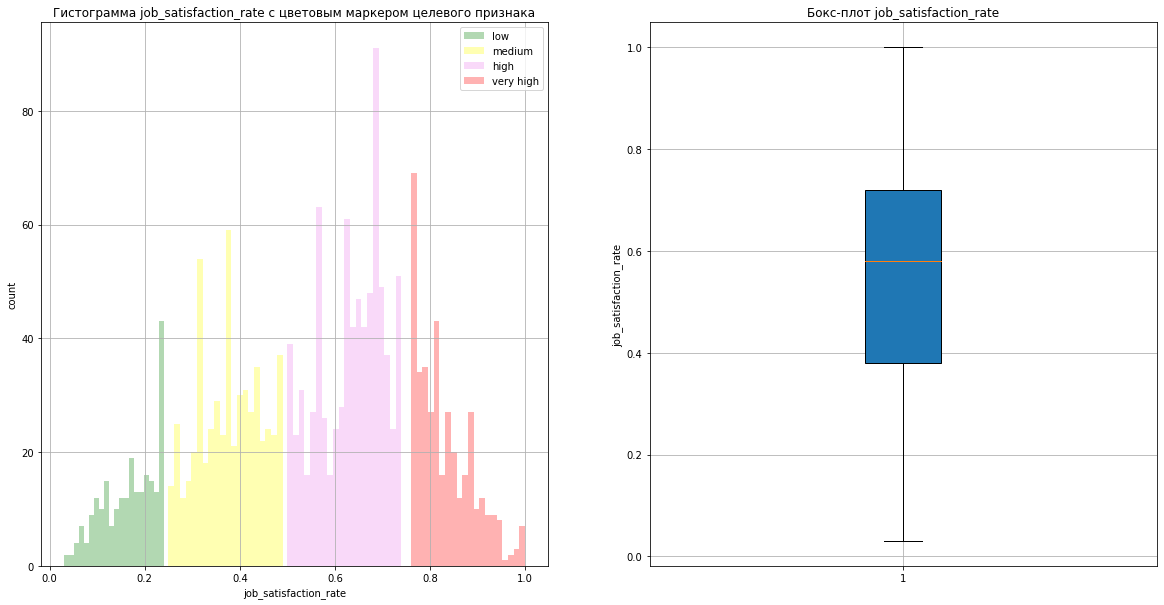

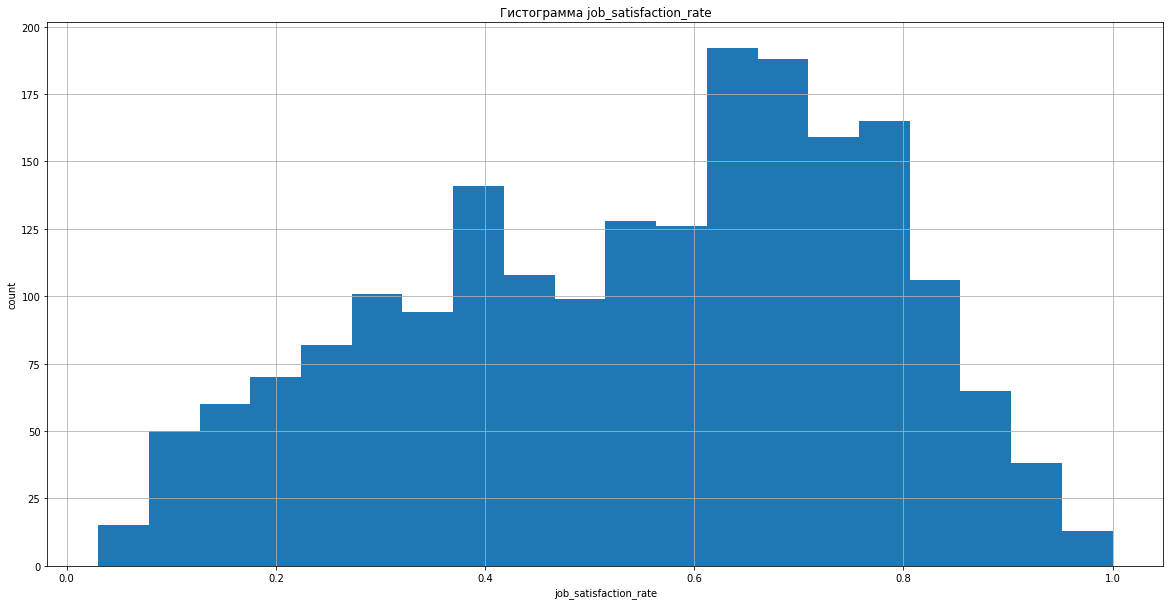

In [ ]:
for colum in ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']:
    print(colum)
    print(df_test_rate[colum].describe())
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    for color, row, leg, width in (['green', 'low', 'low', 0.5],
                            ['yellow', 'medium', 'medium', 0.4],
                            ['Violet', 'high', 'high', 0.3],
                            ['red', 'very high', 'very high', 0.2]):
        x = df_test_rate[df_test_rate['rate_cat'] == row][colum]
        if colum == 'salary' or colum == 'job_satisfaction_rate':
            ax[0].hist(x, bins=20, color=color, alpha=0.3, label=leg)
            ax[0].set_title('Гистограмма ' + colum + ' с цветовым маркером целевого признака')

        else:
            y = list(df_test_rate[colum].unique())
            y.sort()
            x = []
            for i in y:
                l = df_test_rate[(df_test_rate['rate_cat'] == row
                                  ) & (df_test_rate[colum] ==i)][colum].count()
                x.append(l)
            ax[0].bar(y, x, alpha=0.3, color=color, width=width, label=leg)
            ax[0].set_title('Столбчатая диаграмма ' + colum + ' с цветовым маркером целевого признака')

    ax[0].set_xlabel(colum)
    ax[0].set_ylabel('count')
    ax[0].legend(loc="best")
    ax[0].grid(True)

    ax[1].boxplot(df_test_rate[colum], patch_artist=True)
    ax[1].set_ylabel(colum)
    ax[1].set_title('Бокс-плот ' + colum)
    ax[1].grid(True)
    plt.show()

    fig, ax = plt.subplots(figsize=(20, 10))
    x = df_test_rate[colum]
    if colum == 'salary' or colum == 'job_satisfaction_rate':
        plt.hist(x, bins=20)
        plt.title('Гистограмма ' + colum)

    else:
        y = list(df_test_rate[colum].unique())
        y.sort()
        x = []
        for i in y:
            l = df_test_rate[df_test_rate[colum] ==i][colum].count()
            x.append(l)
        plt.bar(y, x, width=0.3)
        plt.title('Столбчатая диаграмма ' + colum)

    plt.xlabel(colum)
    plt.ylabel('count')
    plt.grid(True)
    plt.show()

-**'employment_years'** на train(длительность работы в компании) напоминает распределение Пуасона со 'скосом' к левому краю разброс длительности варьируется от 1 до 10 лет, в среднем 3.71

на train цветовой маркер целевого признака указывает что уровень удовлетворённости сотрудника работой в компании меньше у людей которые меньше проработали

на train аномальных значений не наблюдаем

-Отличия на test: распределение идентично, разброс тот же, среднее значение сместилось 3.66. Закономерности маркера целевого признака не изманились. Аномалий нет

-**'supervisor_evaluation'** на train(оценка качества работы сотрудника, которую дал руководитель) напоминает распределение Пуасона со 'скосом' к правому краю разброс оценки варьируется от 1 до 5, в среднем 3.47

на train уровень удовлетворённости больше у сотрудников оцененных 4 или 5

на train '1' является слегка выбивающимся значением от общей массы

-Отличия на test: распределение идентично, разброс тот же, среднее значение сместилось 3.52. Закономерности маркера целевого признака не изманились. '1' так же слегка выбивающиеся значение из общей массы

-**'salary'** на train(ежемесячная зарплата сотрудника) напоминает нормальное распределение со 'скосом' к левому краю разброс зарплаты варьируется от 12000 до 98400, в среднем 33926

на train уровень удовлетворённости идентичный на почти всех уровнях зарплаты, только у слегка выбивающихся значений по правому краю уровень выше

на train значения находящиеся в правой части распределения слегка выбиваются из общей массы

-Отличия на test: распределение идентично, максимальное значение зарплаты сместилось в чуть меньшую сторону 96000, среднее значение слегка сместилось 34066. Закономерности маркера целевого признака не изманились. Идентичные значения находящиеся в правой части распределения слегка выбивающиеся из общей массы

-**'job_satisfaction_rate'** на train(уровень удовлетворённости сотрудника работой в компании, целевой признак) напоминает нормальное распределение разброс уровня варьируется от 0.03 до 1, в среднем 0.53

на train аномальных значений не наблюдаем

-Отличия на test: распределение смещенно вправо напоминает нормальное, разброс тот же, среднее значение слегка сместилось 0.54. Аномалий нет

### Корреляционный анализ (train)

Построим "хитмап" по матрице корреляций Фика, посмотрим на связь признаков с целевой переменной и для отслеживания мультиколлинеарности

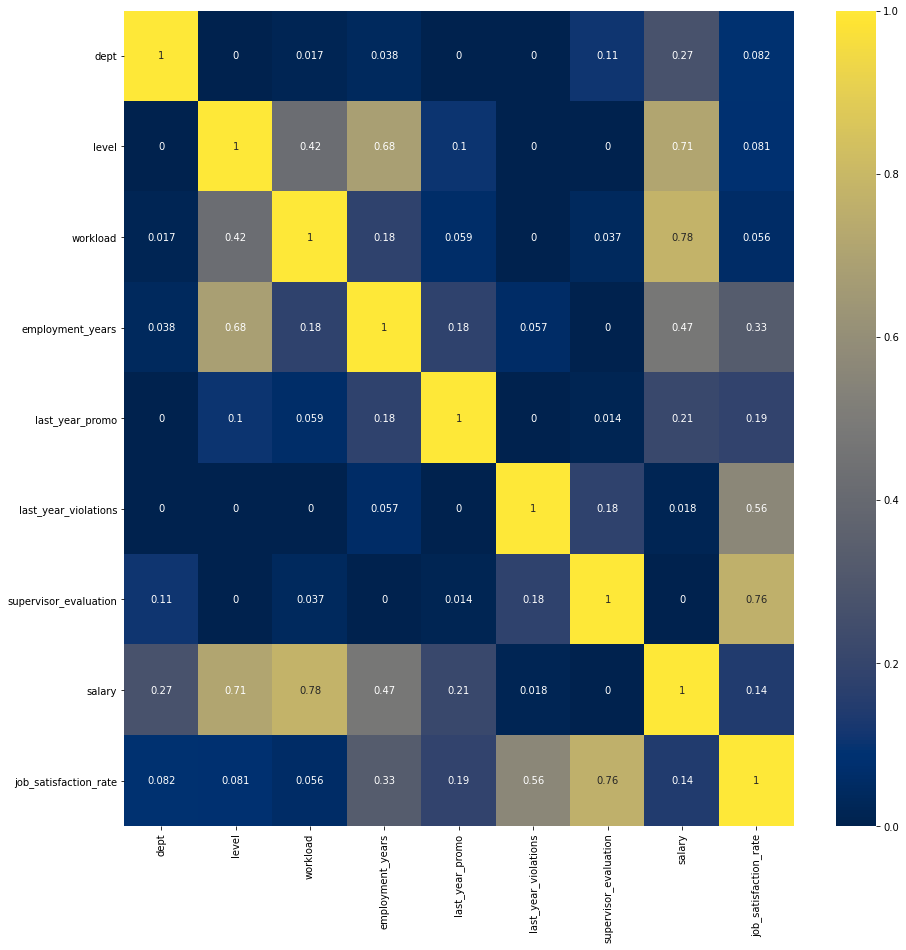

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df_train_rate[['dept', 'level', 'workload',
                           'employment_years', 'last_year_promo',
                           'last_year_violations', 'supervisor_evaluation',
                           'salary', 'job_satisfaction_rate'
                          ]].phik_matrix(interval_cols = ['salary', 'job_satisfaction_rate']
                                        ),annot=True, cmap='cividis').legend = False

Мультиколлинеарности в данных не прослеживается

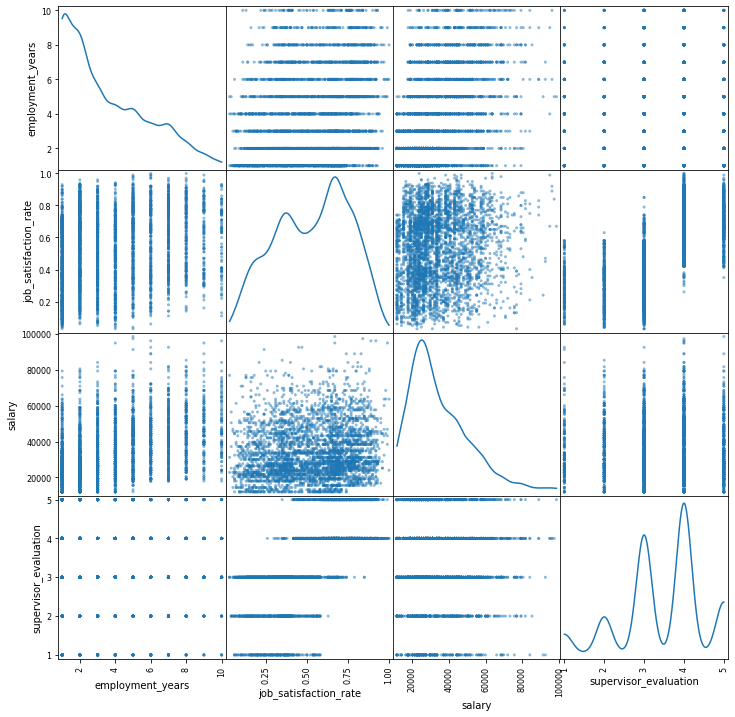

In [ ]:
corr_multi = df_train_rate.pivot_table(index='id', values=df_train_rate.columns[1:], aggfunc='mean')
sm = pd.plotting.scatter_matrix(corr_multi, figsize=(12, 12), diagonal='kde')

plt.show()

Построим scatter графики кол-ых признаков относительно целевого, с цветовым маркером категориальных переменных

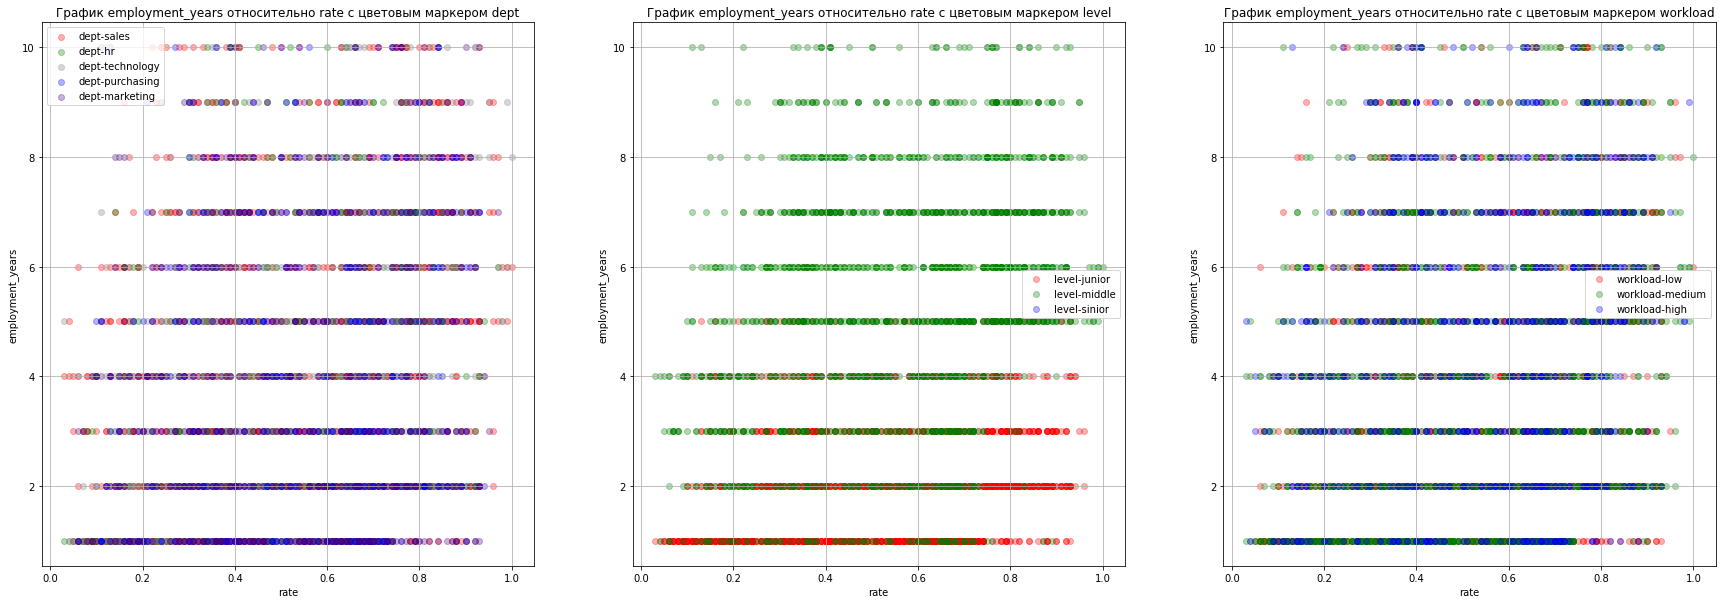

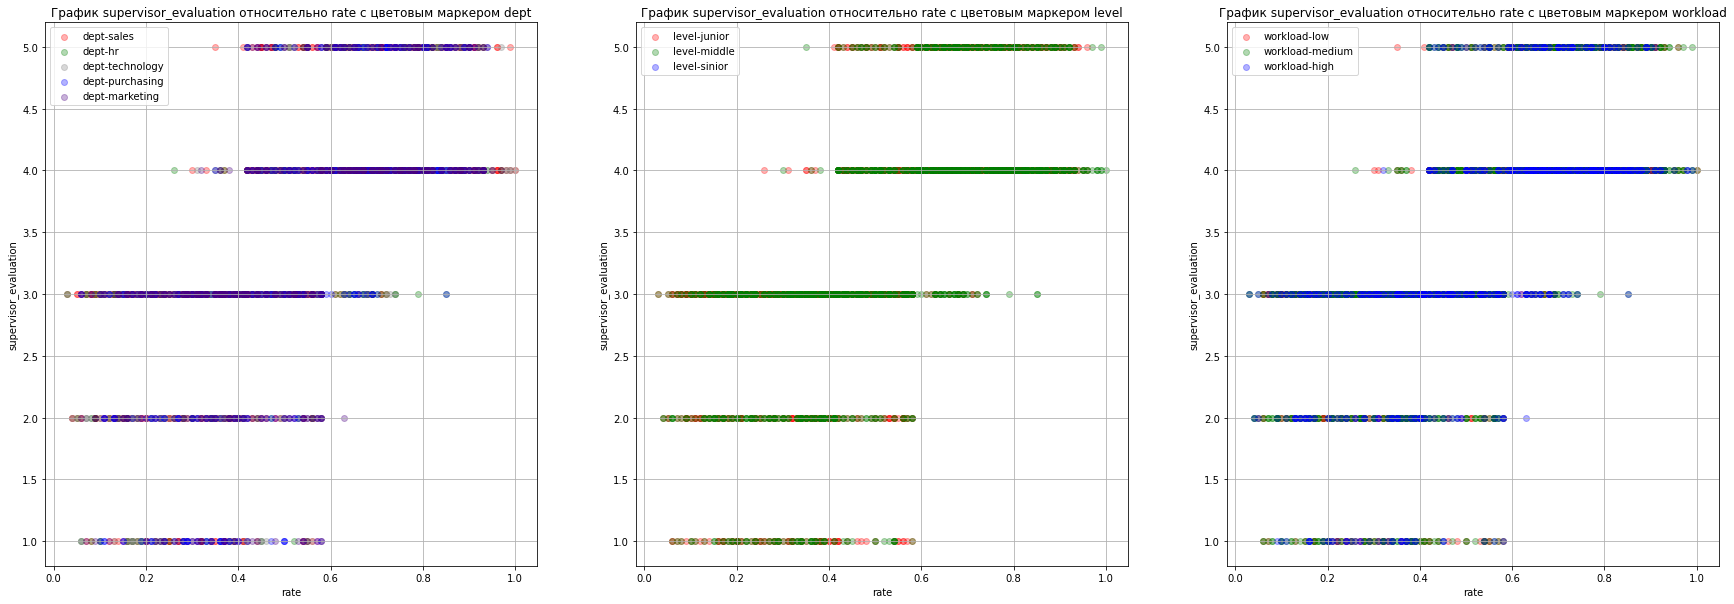

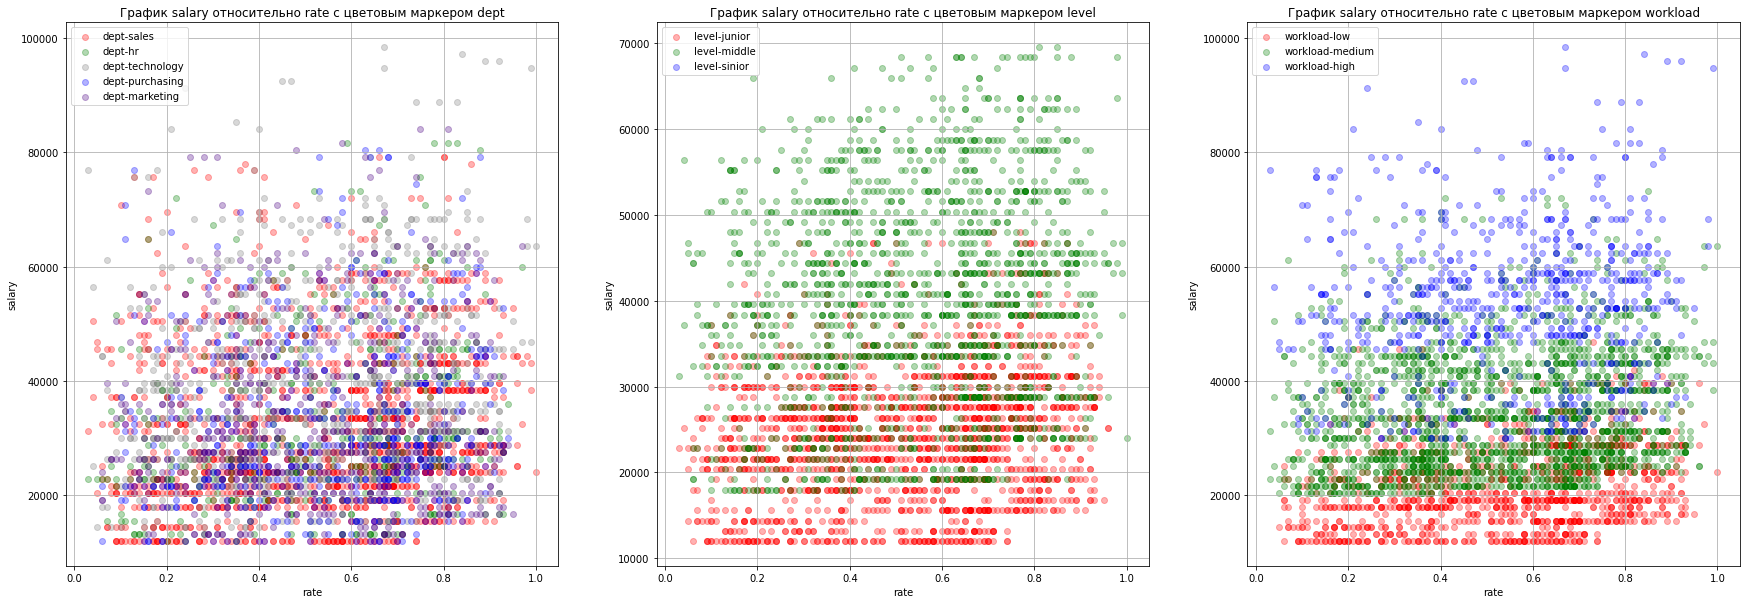

In [ ]:
lis = [['red', 'dept', 'sales', 'sales', 0],
        ['green', 'dept', 'hr', 'hr', 0],
        ['Grey', 'dept', 'technology', 'technology', 0],
        ['blue', 'dept', 'purchasing', 'purchasing', 0],
        ['Indigo', 'dept', 'marketing', 'marketing', 0],
        ['red', 'level', 'junior', 'junior', 1],
        ['green', 'level', 'middle', 'middle', 1],
        ['blue', 'level', 'sinior', 'sinior', 1],
        ['red', 'workload', 'low', 'low', 2],
        ['green', 'workload', 'medium', 'medium', 2],
        ['blue', 'workload', 'high', 'high', 2]]

for colum in 'employment_years', 'supervisor_evaluation', 'salary':
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
  for color, colum1, row, leg, n in lis:
      y = df_train_rate[df_train_rate[colum1] == row][colum]
      x = df_train_rate[df_train_rate[colum1] == row]['job_satisfaction_rate']
      ax[n].scatter(x, y, c=color, alpha=0.3, label=colum1+'-'+leg)

  ax[0].set_xlabel('rate')
  ax[0].set_ylabel(colum)
  ax[0].legend(loc="best")
  ax[0].set_title('График ' + colum + ' относительно rate с цветовым маркером dept')
  ax[0].grid(True)
  ax[1].set_xlabel('rate')
  ax[1].set_ylabel(colum)
  ax[1].legend(loc="best")
  ax[1].set_title('График ' + colum + ' относительно rate с цветовым маркером level')
  ax[1].grid(True)
  ax[2].set_xlabel('rate')
  ax[2].set_ylabel(colum)
  ax[2].legend(loc="best")
  ax[2].set_title('График ' + colum + ' относительно rate с цветовым маркером workload')
  ax[2].grid(True)

  plt.show()

-**employment_years(длительность работы в компании) относительно rate**:

уровень удовлетворённости сотрудника работой в компании меньше у людей которые меньше проработали

цветовой маркер dept(отдел, в котором работает сотрудник) случаен

цветовой маркер level(уровень занимаемой должности) наблюдаем что чем дольше сотрудник работает тем выше занимаемая должность

цветовой маркер workload(уровень загруженности сотрудника) случаен

-**supervisor_evaluation(оценка качества работы сотрудника, которую дал руководитель) относительно rate**:

уровень удовлетворённости выше у сотрудников оцененных на 4 или 5

цветовой маркер dept(отдел, в котором работает сотрудник) случаен

цветовой маркер level(уровень занимаемой должности) случаен

цветовой маркер workload(уровень загруженности сотрудника) случаен

-**salary(ежемесячная зарплата сотрудника) относительно rate**:

уровень удовлетворённости идентичный на почти всех уровнях зарплаты, свыше 60000 кластер слегка смещается в сторону повышенной удовлетворенности

цветовой маркер dept(отдел, в котором работает сотрудник) случаен

цветовой маркер level(уровень занимаемой должности) наблюдаем что чем больше у сотрудника зарплата тем выше занимаемая должность

цветовой маркер workload(уровень загруженности сотрудника) чем выше у сотрудника загруженность тем выше у него зарплата


### Корреляционный анализ (test)

Построим "хитмап" по матрице корреляций Фика, посмотрим на связь признаков с целевой переменной и для отслеживания мультиколлинеарности

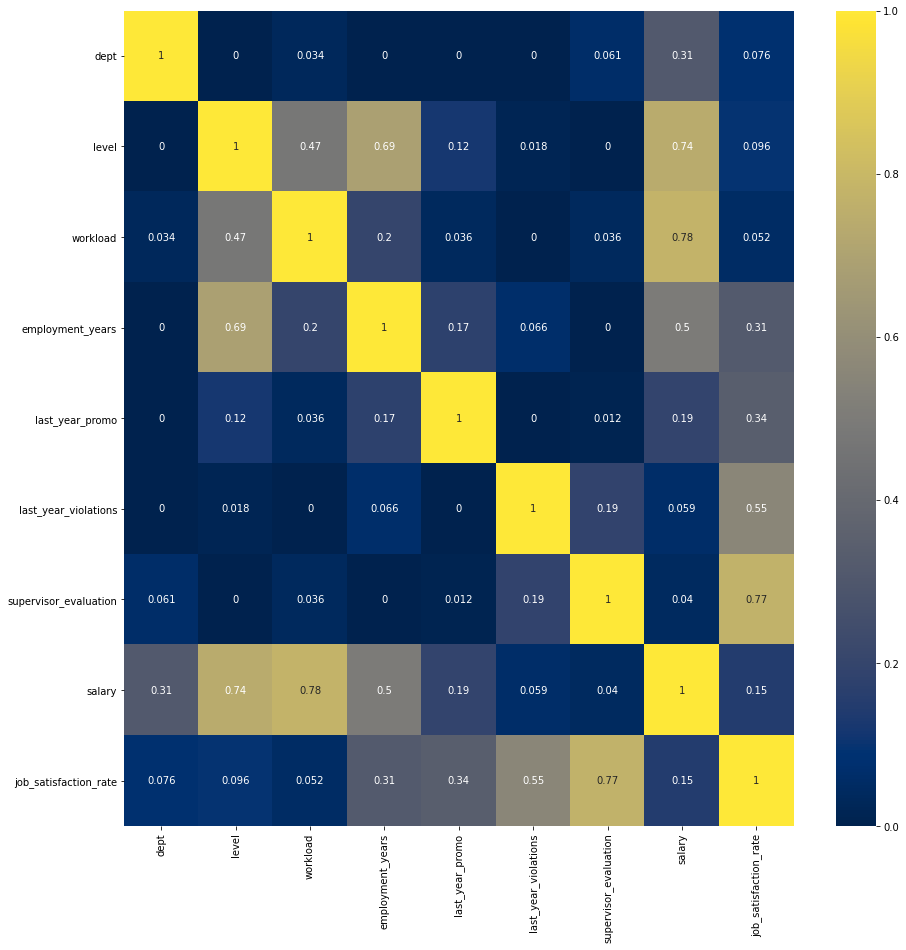

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(pd.concat([X_test_rate[['dept', 'level',
                                    'workload', 'employment_years',
                                    'last_year_promo', 'last_year_violations',
                                    'supervisor_evaluation', 'salary']],
                       y_test_rate['job_satisfaction_rate']], axis=1
                     ).phik_matrix(interval_cols = ['salary', 'job_satisfaction_rate']
                                  ),annot=True, cmap='cividis').legend = False

Мультиколлинеарности в данных не прослеживается

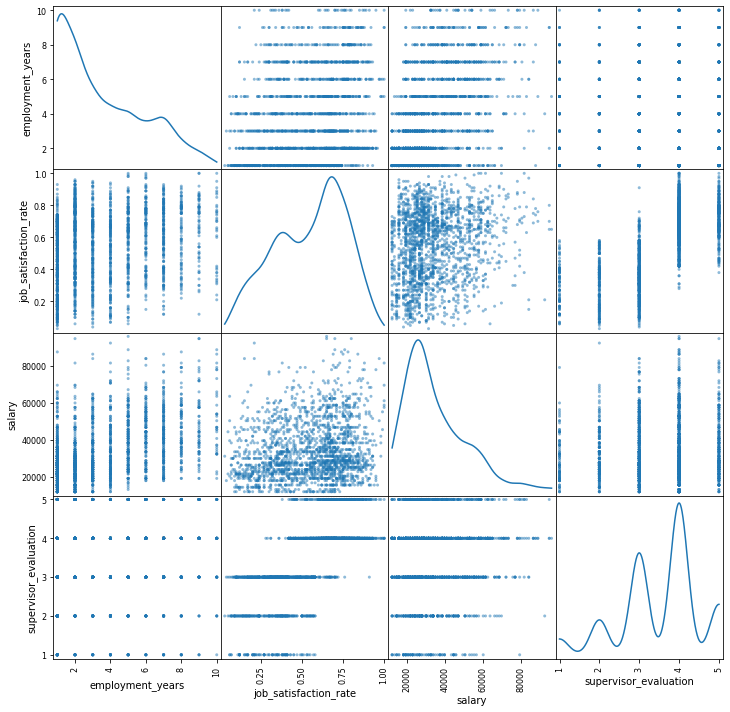

In [ ]:
corr_multi = df_test_rate.pivot_table(index='id', values=df_test_rate.columns[1:], aggfunc='mean')
sm = pd.plotting.scatter_matrix(corr_multi, figsize=(12, 12), diagonal='kde')

plt.show()

Построим scatter графики кол-ых признаков относительно целевого, с цветовым маркером категориальных переменных

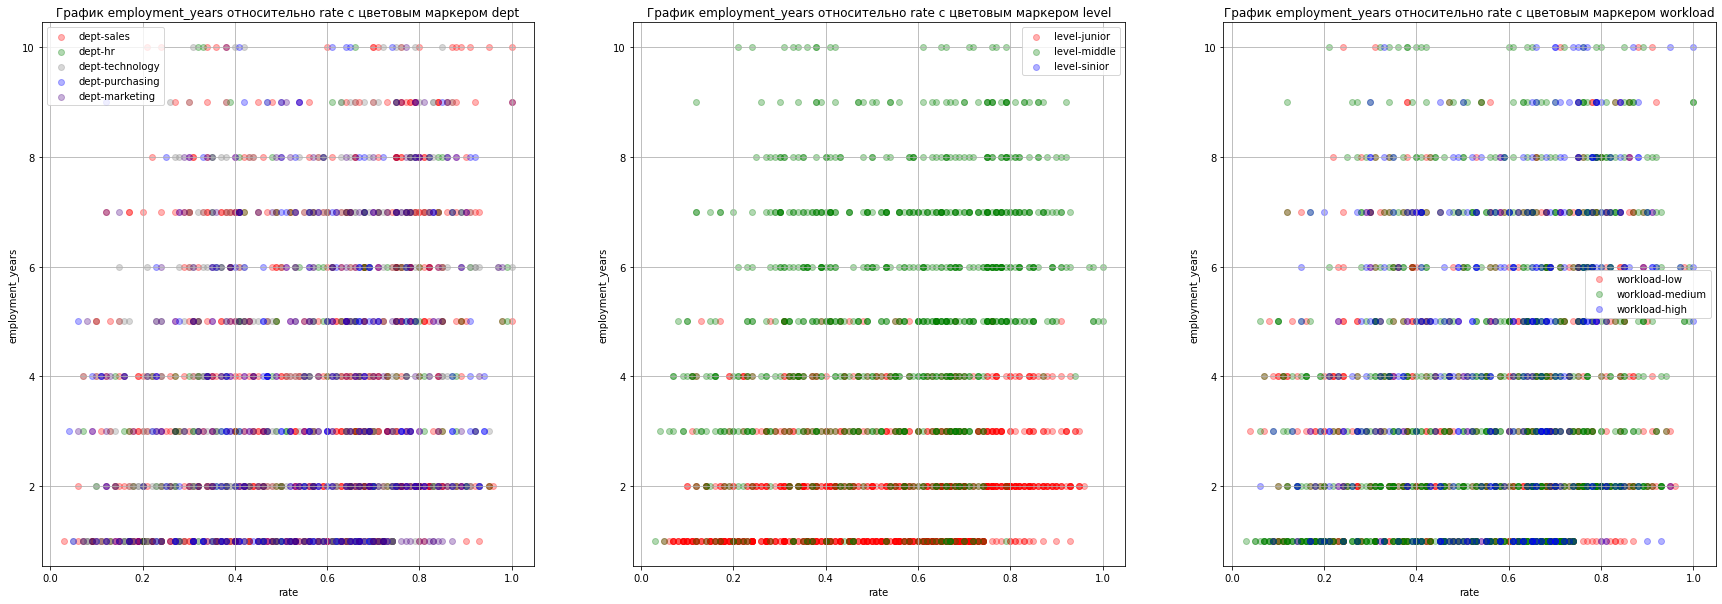

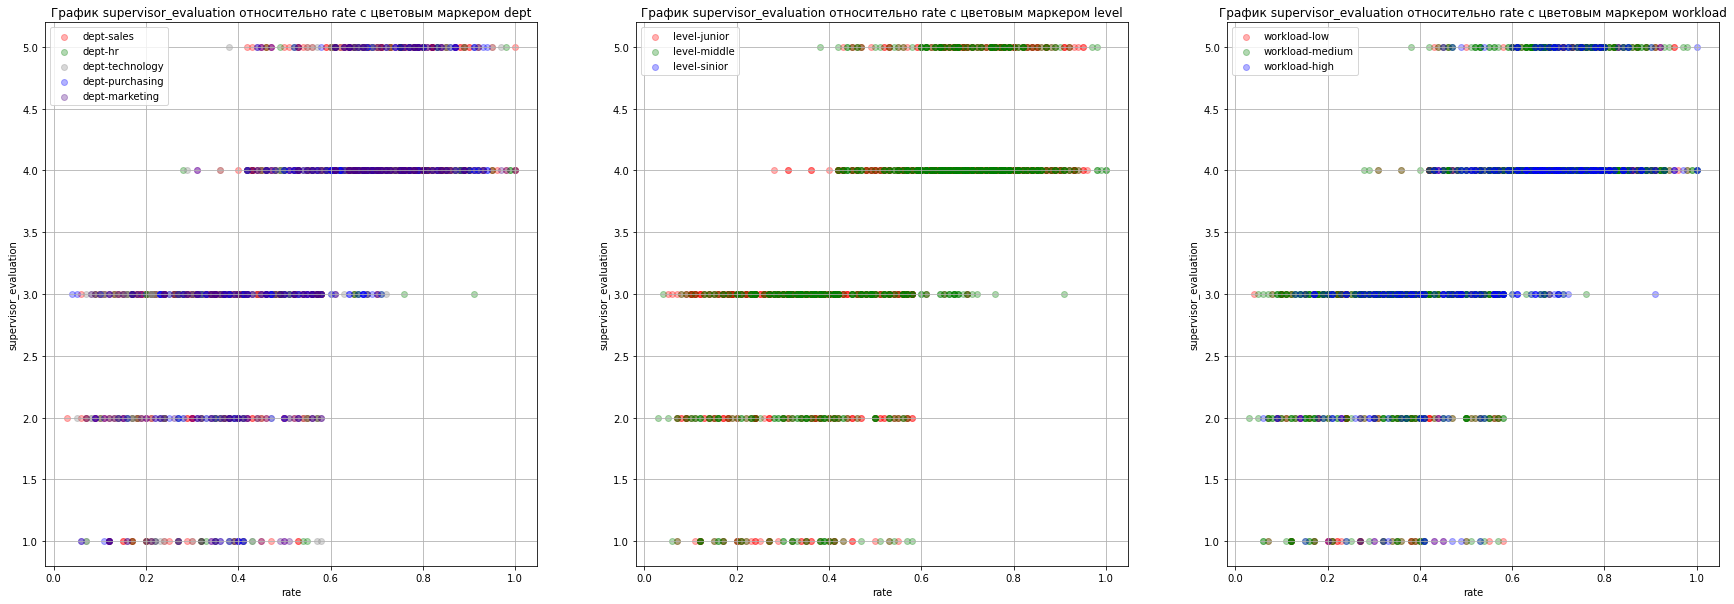

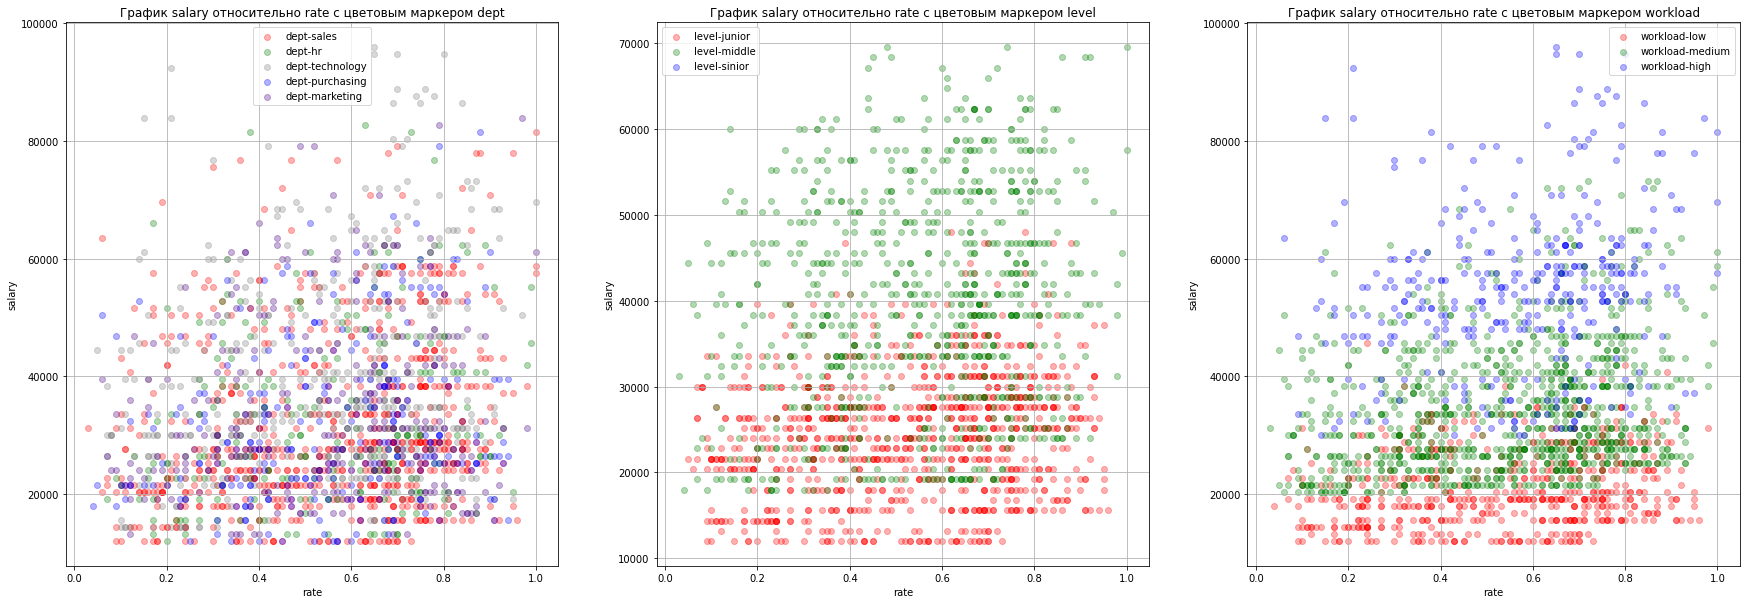

In [ ]:
lis = [['red', 'dept', 'sales', 'sales', 0],
        ['green', 'dept', 'hr', 'hr', 0],
        ['Grey', 'dept', 'technology', 'technology', 0],
        ['blue', 'dept', 'purchasing', 'purchasing', 0],
        ['Indigo', 'dept', 'marketing', 'marketing', 0],
        ['red', 'level', 'junior', 'junior', 1],
        ['green', 'level', 'middle', 'middle', 1],
        ['blue', 'level', 'sinior', 'sinior', 1],
        ['red', 'workload', 'low', 'low', 2],
        ['green', 'workload', 'medium', 'medium', 2],
        ['blue', 'workload', 'high', 'high', 2]]

for colum in 'employment_years', 'supervisor_evaluation', 'salary':
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
  for color, colum1, row, leg, n in lis:
      y = df_test_rate[df_test_rate[colum1] == row][colum]
      x = df_test_rate[df_test_rate[colum1] == row]['job_satisfaction_rate']
      ax[n].scatter(x, y, c=color, alpha=0.3, label=colum1+'-'+leg)

  ax[0].set_xlabel('rate')
  ax[0].set_ylabel(colum)
  ax[0].legend(loc="best")
  ax[0].set_title('График ' + colum + ' относительно rate с цветовым маркером dept')
  ax[0].grid(True)
  ax[1].set_xlabel('rate')
  ax[1].set_ylabel(colum)
  ax[1].legend(loc="best")
  ax[1].set_title('График ' + colum + ' относительно rate с цветовым маркером level')
  ax[1].grid(True)
  ax[2].set_xlabel('rate')
  ax[2].set_ylabel(colum)
  ax[2].legend(loc="best")
  ax[2].set_title('График ' + colum + ' относительно rate с цветовым маркером workload')
  ax[2].grid(True)

  plt.show()

Патерн цветового маркера категориальных переменных на scatter целевого признака и кол-ых переменных идентичный train выборке


### Подготовка данных

Выделим 'фичи' и целевую переменную из тренировочного фрейма

In [ ]:
X_train_rate = df_train_rate.drop(['rate_cat','id', 'job_satisfaction_rate'], axis=1)
X_train_rate.head()

dept   level workload  employment_years last_year_promo  \
0       sales  junior   medium                 2              no   
1          hr  junior     high                 2              no   
2       sales  junior      low                 1              no   
3  technology  junior      low                 4              no   
4          hr  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      1   24000  
1                   no                      5   38400  
2                   no                      2   12000  
3                   no                      2   18000  
4                   no                      3   22800

In [ ]:
X_train_rate.duplicated().sum()

1492

Наблюдаем что после удаления 'id' и целевого признака появилось 1492 явных дубликата

Проверим сколько явных дубликатов будет если добавить к фрейму целевой признак

In [ ]:
df_train_rate_learn = df_train_rate.drop(['rate_cat','id'], axis=1)
df_train_rate_learn.head()

dept   level workload  employment_years last_year_promo  \
0       sales  junior   medium                 2              no   
1          hr  junior     high                 2              no   
2       sales  junior      low                 1              no   
3  technology  junior      low                 4              no   
4          hr  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      1   24000                   0.58  
1                   no                      5   38400                   0.76  
2                   no                      2   12000                   0.11  
3                   no                      2   18000                   0.37  
4                   no                      3   22800                   0.20

In [ ]:
df_train_rate_learn.duplicated().sum()

245

245 явных дубликатов после удаления 'id' из выборки, их точно удалим

In [ ]:
X_train_rate.duplicated().sum() - df_train_rate_learn.duplicated().sum()

1247

1247 значений с одинаковыми входными признаками но разными результатами целевой переменной, их оставим

In [ ]:
df_train_rate_learn = df_train_rate_learn.drop_duplicates().reset_index(drop=True)
df_train_rate_learn.duplicated().sum()

0

In [ ]:
X_train_rate = df_train_rate_learn.drop('job_satisfaction_rate', axis=1)
X_train_rate.head()

dept   level workload  employment_years last_year_promo  \
0       sales  junior   medium                 2              no   
1          hr  junior     high                 2              no   
2       sales  junior      low                 1              no   
3  technology  junior      low                 4              no   
4          hr  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      1   24000  
1                   no                      5   38400  
2                   no                      2   12000  
3                   no                      2   18000  
4                   no                      3   22800

In [ ]:
y_train_rate = df_train_rate_learn['job_satisfaction_rate']
y_train_rate.head()

0    0.58
1    0.76
2    0.11
3    0.37
4    0.20
Name: job_satisfaction_rate, dtype: float64

Создаем списки с названиями признаков для масштабирования и кодирования

In [ ]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['salary']

Создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование

In [ ]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )

Создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование, категории выделили зарание в ord_cat

In [ ]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

Создаём общий пайплайн для подготовки данных

In [ ]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

Создаём итоговый пайплайн: подготовка данных и модель

In [ ]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

Задаем параметры для кросс-валидации и перебора моделей с гиперпараметрами

In [ ]:
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=42)],
        'models__max_depth': [None] + [i for i in range(2, 7)],
        'models__max_features': range(2, 14, 2),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели Ridge()
    {
        'models': [Ridge(random_state=42)],
        'models__alpha': [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.1, 0.2],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели ElasticNet()
    {
        'models': [ElasticNet(random_state=42)],
        'models__alpha': [0.05, 0.1, 0.2, 0.5, 1],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

### Обучение моделей

#### Подбор модели

Создаем функцию для подсчета метрики SMAPE

In [ ]:
def get_smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    diff = np.abs(y_true - y_pred)
    div = (np.abs(y_true) + np.abs(y_pred)) / 2

    smape = np.mean(diff / div) * 100

    return smape

Сохраняем функцию make_scorer с нашей метрикой и параметром 'greater_is_better=False' для уменьшения метрики при росте качества модели

In [ ]:
smape_score = make_scorer(
    get_smape,
    greater_is_better=False
)

scoring = {
    'smape': smape_score,
}


In [ ]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    n_iter=20,
    scoring=smape_score,
    random_state=42,
    n_jobs=-1
)
randomized_search.fit(X_train_rate, y_train_rate)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', -1*randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

Лучшей моделью на кросс-валидации получилась модель DecisionTreeRegressor(max_features=10, random_state=42) с масштабированием кол-ых признаков StandardScaler()

In [ ]:
print ('Метрика лучшей модели на тестовой выборке:', get_smape(np.asarray(y_test_rate['job_satisfaction_rate']),
                                                                    randomized_search.best_estimator_.predict(X_test_rate.drop('id', axis=1))))

Метрика лучшей модели на тестовой выборке: 14.539001292692841


Метрика получившиеся на тестовых данных соответствует критерию успеха в данной задаче

#### Анализ важности признаков

Обучим лучшую получившиеся модель и взглянем на самые весомые признаки

In [ ]:
model = DecisionTreeRegressor(max_features=10, random_state=42)
model.fit(data_preprocessor.fit_transform(X_train_rate), y_train_rate)

y_test_pred = model.predict(data_preprocessor.fit_transform(X_test_rate.drop('id', axis=1)))

result = cross_val_score(model, data_preprocessor.fit_transform(X_train_rate), y_train_rate, scoring=smape_score)
mn = np.mean(result)
std = np.std(result)

print(f'Метрика smape на кросс-валидации: {-1*mn} с стандартным отклонением: {std}')
print ('Метрика на тестовой выборке:', get_smape(np.asarray(y_test_rate['job_satisfaction_rate']), y_test_pred))

Метрика smape на кросс-валидации: 15.94972924768643 с стандартным отклонением: 0.4640852539275817
Метрика на тестовой выборке: 14.820731870749984


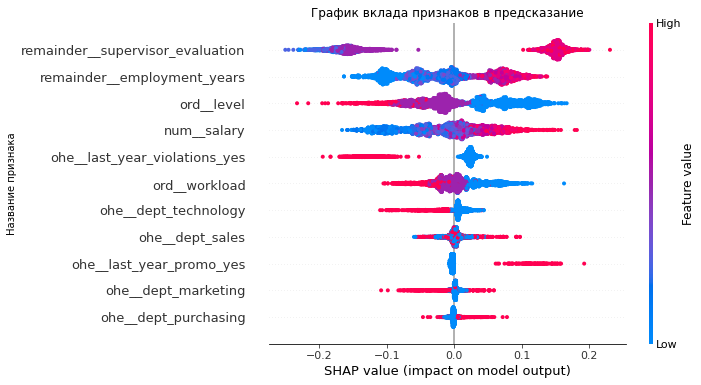

In [ ]:
explainer = shap.TreeExplainer(model, pd.DataFrame(data_preprocessor.fit_transform(X_train_rate), columns=data_preprocessor.fit(X_train_rate).get_feature_names_out()))
shap_values = explainer(data_preprocessor.fit_transform(X_train_rate))

plt.title('График вклада признаков в предсказание')
plt.ylabel('Название признака')
shap.plots.beeswarm(shap_values, max_display=25)

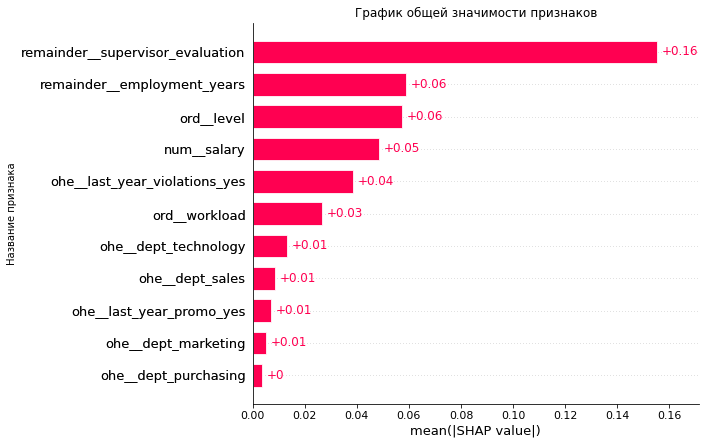

In [ ]:
plt.title('График общей значимости признаков')
plt.ylabel('Название признака')

shap.plots.bar(shap_values, max_display=25)

In [ ]:
data_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['dept', 'last_year_promo',
                                  'last_year_violations']),
                                ('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['junior',
                                                                              'middle',
                                                                              'senior'],
                                                                             ['low',
                                                                              'medium',
                                                                              'high']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan)),
                                                 ('simpleImputer_after_ord',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['level', 'workload']),
                                ('num', MinMaxScaler(), ['salary'])])

Диаграмма иллюстрирует важность признаков. Значения Шепли взято по модулю, чтобы положительные и отрицательные значения не сводили друг друга к нулю. Наблюдаем топ значимости признаков для нашей модели по Шепли, по убыванию значимость признаков: supervisor_evaluation, employment_years, level_ord, salary и тд

Построим константную модель DummyRegressor для сравнения с лучшей получившиеся моделью:

In [ ]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(data_preprocessor.fit_transform(X_train_rate), y_train_rate)

y_test_dummy = dummy_regr.predict(data_preprocessor.fit_transform(X_test_rate.drop('id', axis=1)))

print ('Метрика на тестовой выборке:', get_smape(np.asarray(y_test_rate['job_satisfaction_rate']), y_test_dummy))

Метрика на тестовой выборке: 38.26225790202237


### Промежуточный вывод о модели

Был проведен перебор моделей и их гиперпараметров(DecisionTreeRegressor, Ridge, ElasticNet, LinearRegression) с предобработкой данных в пайплайне с разными методами масштабирования(StandardScaler, MinMaxScaler, 'passthrough') при помощи RandomizedSearchCV на пользовательской метрике SMAPE(подсчет сохранен в функции get_smape).  Лучшей моделью на кросс-валидации получилась модель DecisionTreeRegressor(max_features=10, random_state=42) с масштабированием кол-ых признаков StandardScaler()

Метрика smape на кросс-валидации: 15.949729247686468 с стандартным отклонением: 0.464085253927581

Метрика на тестовой выборке: 14.820731870750024

Построенна константная модель DummyRegressor для проверки лучшей модели на адекватность:

Метрика на тестовой выборке: 38.26225790202237

# Задача 2: предсказание увольнения сотрудника из компании

### Загрузка данных

Данные представленны в 3 файлах, прочитаем их и сохраним

In [ ]:
df_train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv', sep = ',')
X_test_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv', sep=',')
y_test_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv', sep=',')

In [ ]:
df_train_quit.head()

id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  
0                   no                      4   54000   no  
1                   no                      4   27600   no  
2                   no                      1   37200   no  
3                  yes                      3   24000  yes  
4                   no                      5   25200   no

In [ ]:
df_train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


В первой таблице 6 колонок типа object: dept, level, workload, last_year_promo, last_year_violations, quit;

4 колонки типа int: id, employment_years, supervisor_evaluation, salary;

In [ ]:
X_test_quit.head()

id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800

In [ ]:
X_test_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Во второй таблице колонки идентичны 1-ой таблице за исключением целевого признака quit

In [ ]:
y_test_quit.head()

id quit
0  999029  yes
1  372846   no
2  726767   no
3  490105   no
4  416898  yes

In [ ]:
y_test_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


В третьей таблице колонка типа int (id) и целевой признак типа object: quit

### Предобработка данных

#### Пропуски и дубликаты

Проверим наличие пропусков в данных

In [ ]:
df_train_quit.isna().mean()

id                       0.0
dept                     0.0
level                    0.0
workload                 0.0
employment_years         0.0
last_year_promo          0.0
last_year_violations     0.0
supervisor_evaluation    0.0
salary                   0.0
quit                     0.0
dtype: float64

In [ ]:
X_test_quit.isna().mean()

id                       0.0000
dept                     0.0010
level                    0.0005
workload                 0.0000
employment_years         0.0000
last_year_promo          0.0000
last_year_violations     0.0000
supervisor_evaluation    0.0000
salary                   0.0000
dtype: float64

In [ ]:
y_test_quit.isna().mean()

id      0.0
quit    0.0
dtype: float64

Пропусков не обнаружено

Проверим дубликаты в данных

In [ ]:
df_train_quit.duplicated().sum()

0

In [ ]:
X_test_quit.duplicated().sum()

0

In [ ]:
y_test_quit.duplicated().sum()

0

Явных дубликатов нет

In [ ]:
X_test_quit.head()

id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800

In [ ]:
y_test_quit.head()

id quit
0  999029  yes
1  372846   no
2  726767   no
3  490105   no
4  416898  yes

In [ ]:
df_train_quit.head()

id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  
0                   no                      4   54000   no  
1                   no                      4   27600   no  
2                   no                      1   37200   no  
3                  yes                      3   24000  yes  
4                   no                      5   25200   no

In [ ]:
df_train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


Типы данных в таблицах представленноы корректно

#### Неявные дубликаты

Проверим уникальные значения категориальных переменных

In [ ]:
df_train_quit['dept'].unique()

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

Значение 'sinior' носит грамматическую ошибку, исправим это

In [ ]:
df_train_quit['level'].unique()

array(['middle', 'junior', 'sinior'], dtype=object)

In [ ]:
df_train_quit['level'] = df_train_quit['level'].apply(lambda x: 'senior' if x == 'sinior'  else x)

In [ ]:
df_train_quit['level'].unique()

array(['middle', 'junior', 'senior'], dtype=object)

In [ ]:
df_train_quit['workload'].unique()

array(['high', 'medium', 'low'], dtype=object)

In [ ]:
df_train_quit['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [ ]:
df_train_quit['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [ ]:
X_test_quit['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

Значение ' ' заменим на пропуск nan

In [ ]:
X_test_quit['dept'] = X_test_quit['dept'].apply(lambda x: np.nan if x == ' '  else x)

In [ ]:
X_test_quit['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

Грамматическая ошибка значения 'sinior'

In [ ]:
X_test_quit['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [ ]:
X_test_quit['level'] = X_test_quit['level'].apply(lambda x: 'senior' if x == 'sinior'  else x)

In [ ]:
X_test_quit['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [ ]:
X_test_quit['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

' ' заменим на nan

In [ ]:
X_test_quit['workload'] = X_test_quit['workload'].apply(lambda x: np.nan if x == ' '  else x)

In [ ]:
X_test_quit['workload'].unique()

array(['medium', 'low', 'high', nan], dtype=object)

In [ ]:
X_test_quit['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [ ]:
X_test_quit['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [ ]:
X_test_quit.duplicated().sum()

0

Явных дубликатов не появилось

#### Работа с порядком id

In [ ]:
pd.concat([y_test_quit['id'], X_test_quit['id']], axis=1).head()

id      id
0  999029  485046
1  372846  686555
2  726767  467458
3  490105  418655
4  416898  789145

Порядок id у целевого признака тестовых данных не соответствует id входных признаков

Соберем входные и целевой признак в один фрейм отсортировав целевой признак по id

In [ ]:
df_test_quit = X_test_quit.merge(y_test_quit,on='id', how='inner')
df_test_quit.head()

id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary quit  
0                   no                      5   28800   no  
1                   no                      4   30000   no  
2                   no                      4   19200   no  
3                   no                      4   19200   no  
4                   no                      5   40800   no

In [ ]:
y_test_quit[['id', 'quit']] = df_test_quit[['id', 'quit']]
y_test_quit

id quit
0     485046   no
1     686555   no
2     467458   no
3     418655   no
4     789145   no
...      ...  ...
1995  393147  yes
1996  109582  yes
1997  305653  yes
1998  160233   no
1999  771859   no

[2000 rows x 2 columns]

In [ ]:
pd.concat([y_test_quit['id'], X_test_quit['id']], axis=1).head(10)

id      id
0  485046  485046
1  686555  686555
2  467458  467458
3  418655  418655
4  789145  789145
5  429973  429973
6  850699  850699
7  500791  500791
8  767867  767867
9  937235  937235

### Исследовательский анализ данных (train)

#### Категориальные признаки

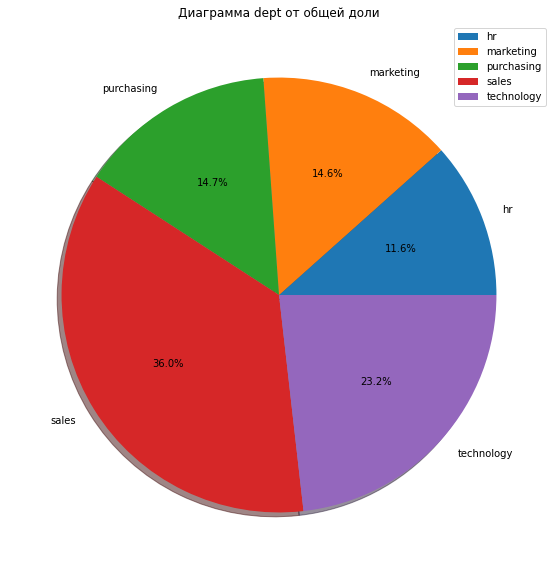

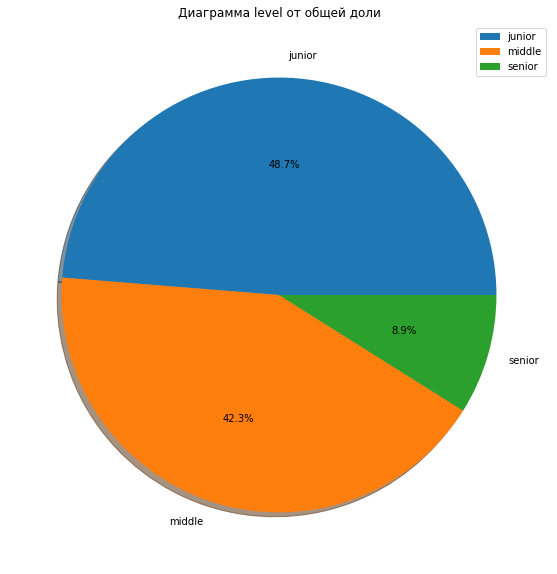

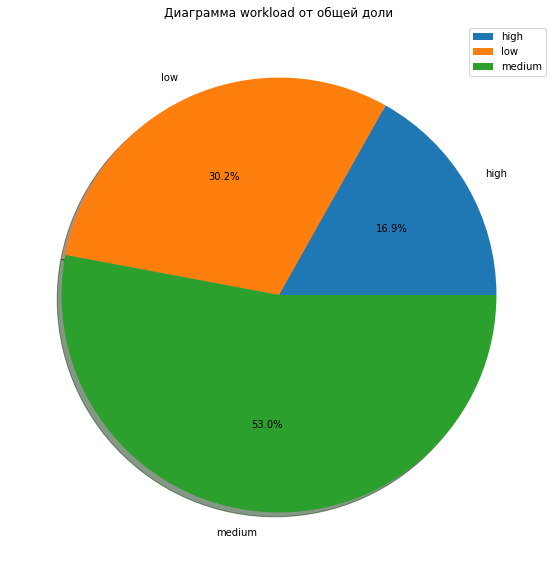

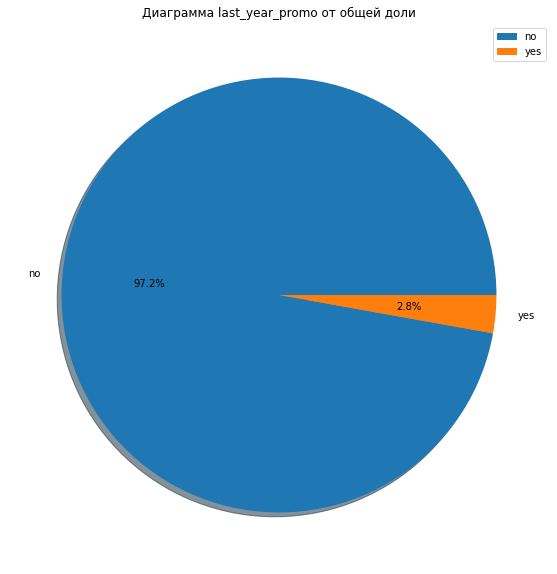

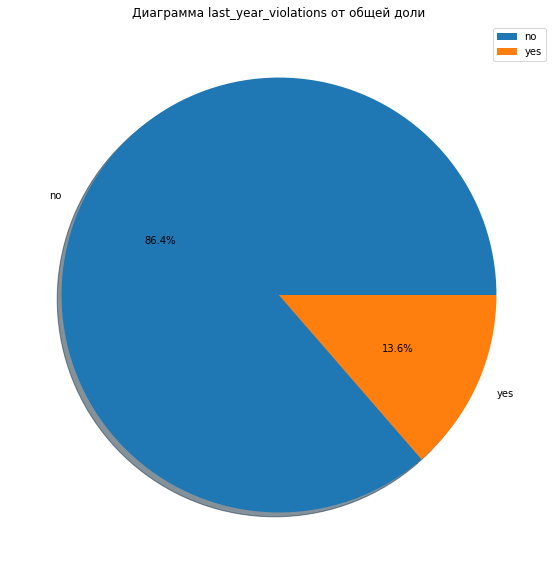

In [ ]:
for colum in ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']:
    fig, ax = plt.subplots(figsize=(12, 10))
    x = df_train_quit.groupby(colum)['id'].count()
    x = (x/len(df_train_quit) * 100).reset_index()
    labels = x[colum]
    x = x['id']
    plt.pie(x, labels=labels, autopct='%1.1f%%', shadow=True)
    plt.legend(loc="best")
    plt.title('Диаграмма '+ colum +' от общей доли')
    plt.show()

-Значения 'dept'( отдела, в котором работает сотрудник) делятся на 5 частей, чаще всего встречается отдел 'sales'(36%), по убыванию: 'technology'(23.2%), 'marketing'(14.6%), 'purchasing'(14.7%), hr(11.6%)

-Значения 'level'(уровень занимаемой должности) делятся на 3 частей, чаще всего встречается уровень 'junior'(48.7%), 'middle'(42.3%), реже всего встречается 'sinior'(8.9%)

-Значения 'workload'(уровень загруженности сотрудника) делятся на 3 частей, чаще всего встречается уровень 'medium'(53%), 'low'(30.2%), реже всего встречается 'high'(16.9%)

-Значения 'last_year_promo'(было ли повышение за последний год) делятся на 2 части, чаще всего встречается знаяение 'no'(97.2%), реже встречается 'yes'(2.8%)

-Значения 'last_year_violations'(нарушал ли сотрудник трудовой договор за последний год) делятся на 2 части, чаще всего встречается знаяение 'no'(86.4%), реже встречается 'yes'(13.6%)

#### Кол-ые признаки

Обозначим цветовым маркером целевой признак на гистограммах кол-ых признаков

employment_years
count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


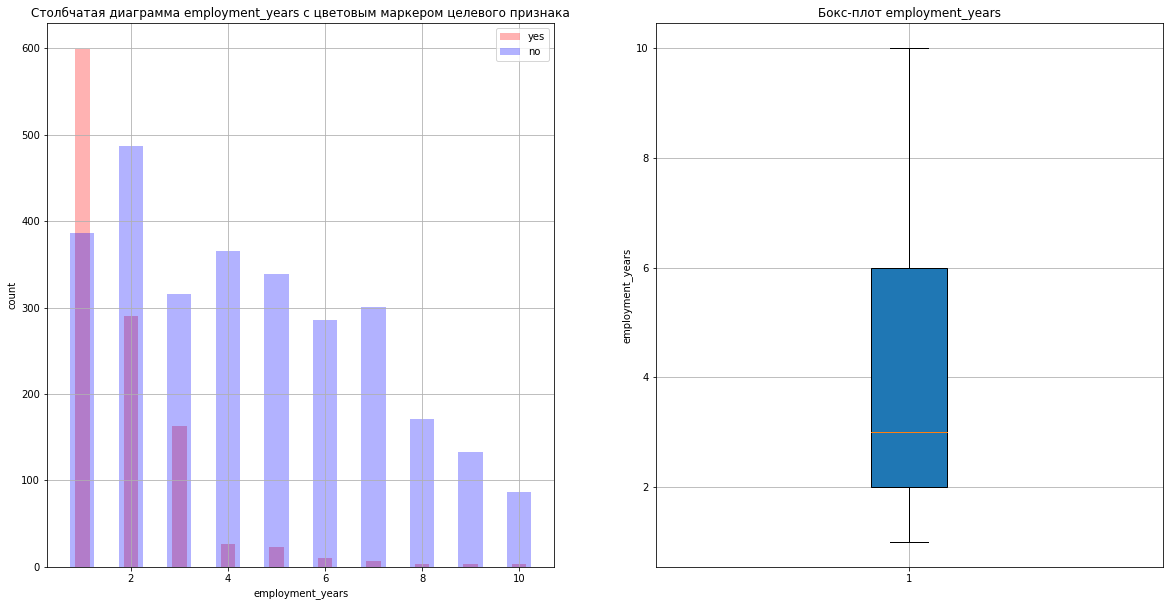

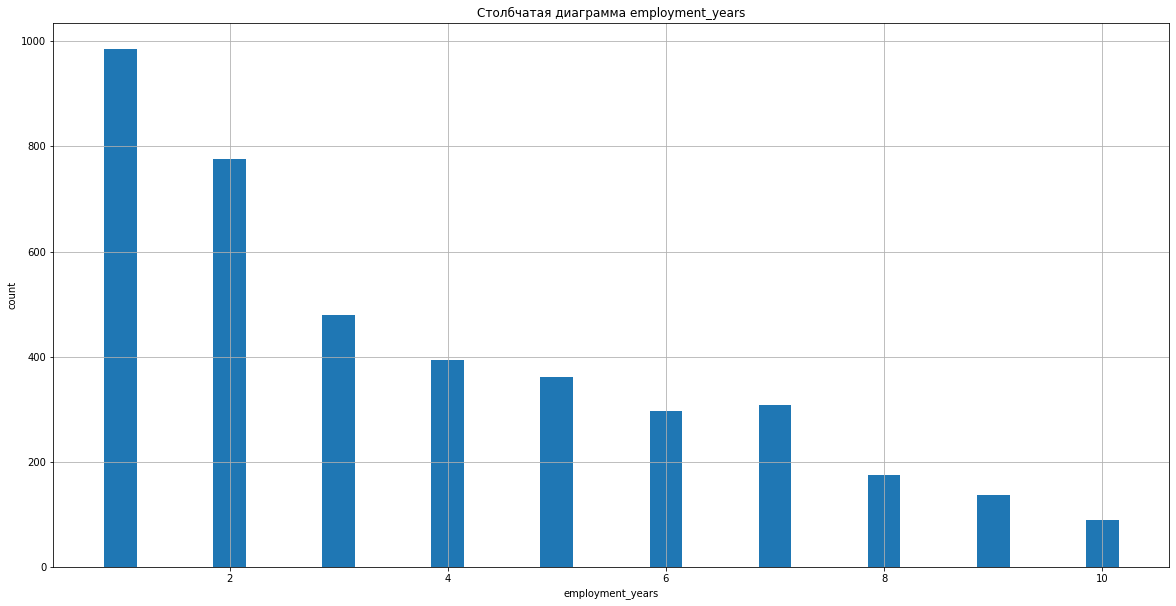

supervisor_evaluation
count    4000.000000
mean        3.474750
std         1.004049
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


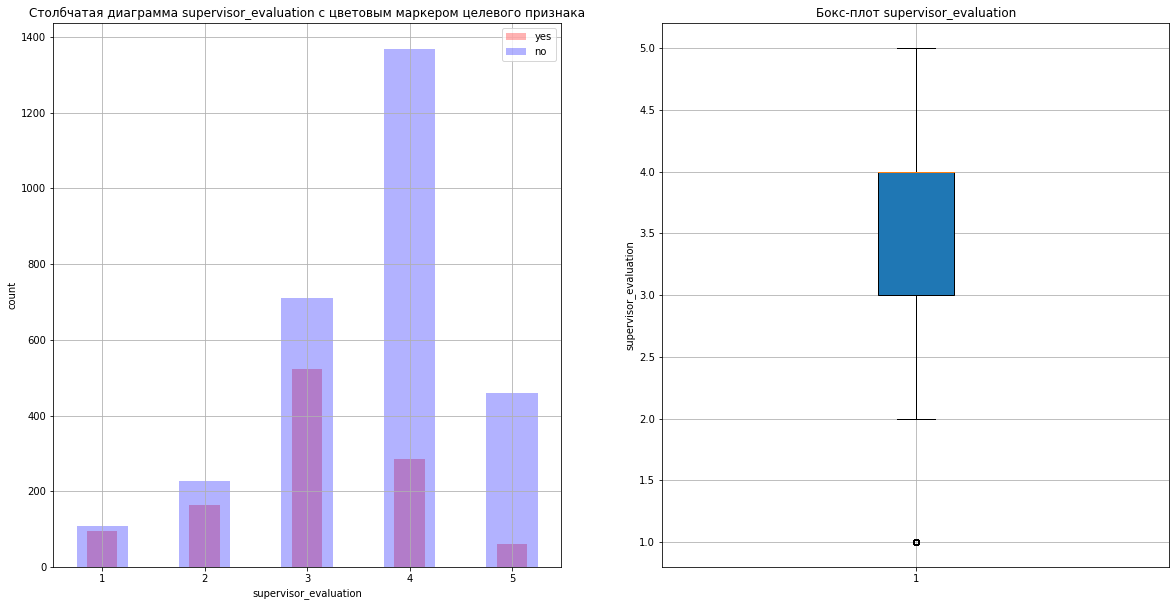

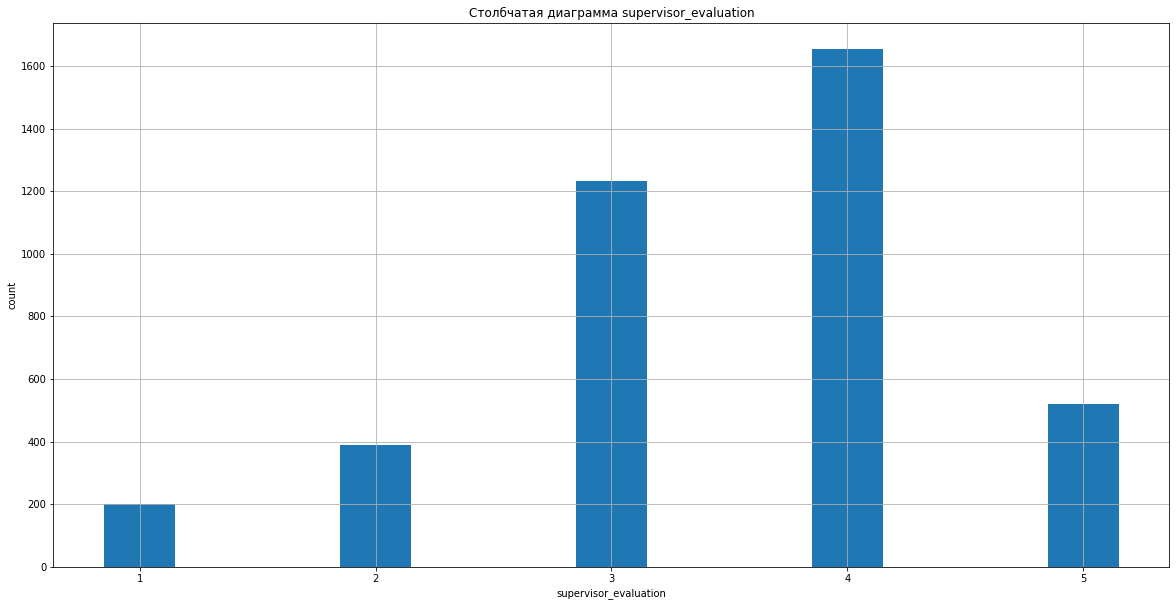

salary
count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


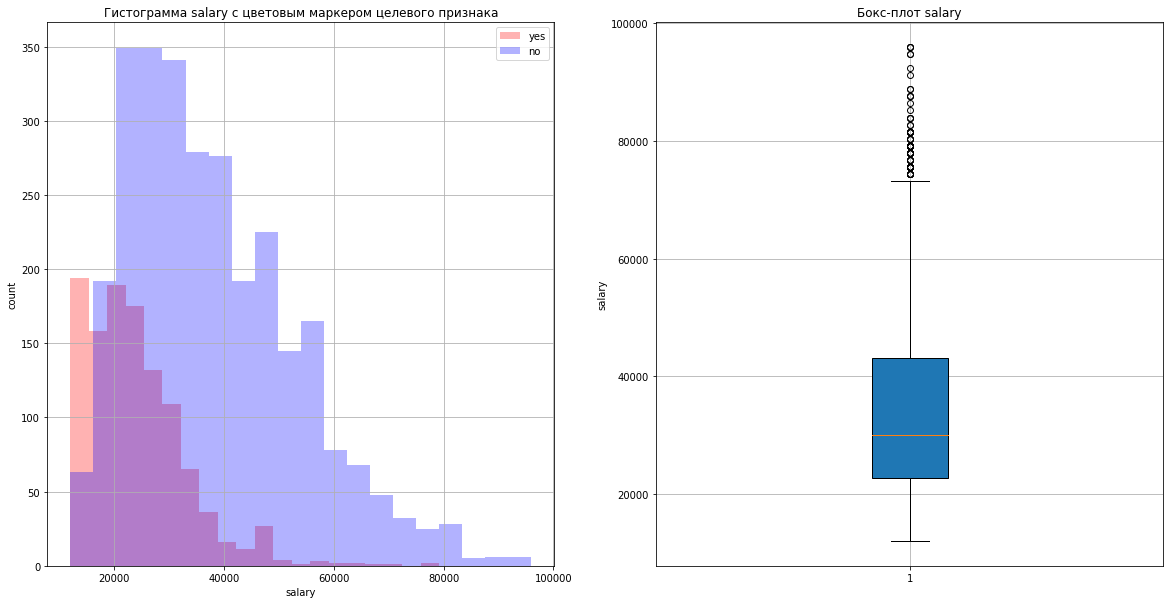

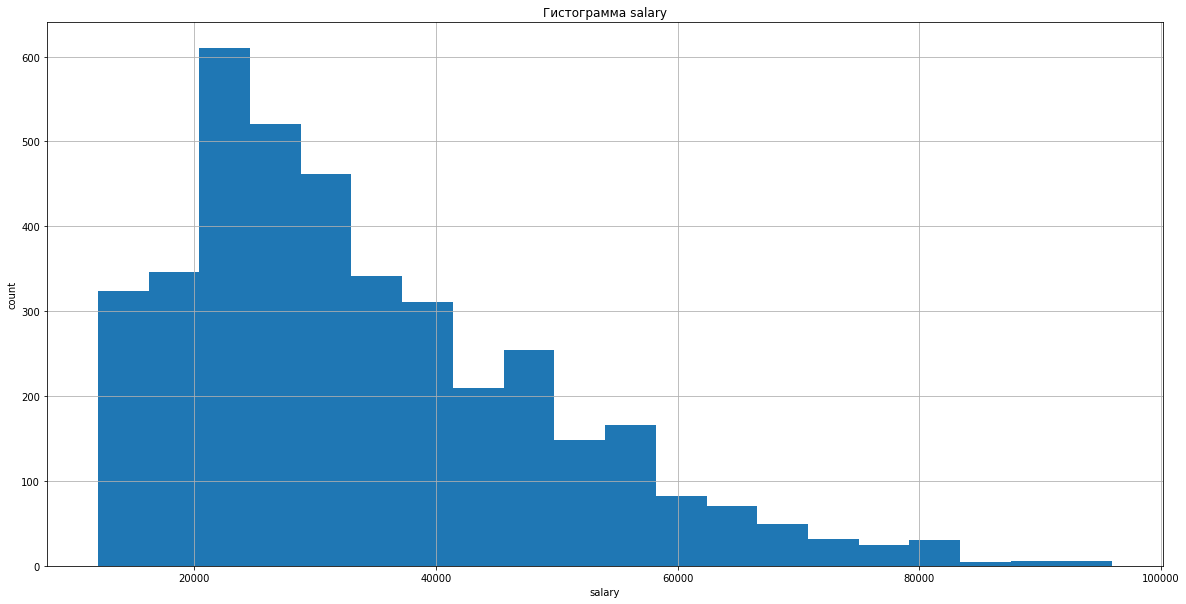

In [ ]:
for colum in ['employment_years', 'supervisor_evaluation', 'salary']:
    print(colum)
    print(df_train_quit[colum].describe())
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    for color, row, leg, width in (['red', 'yes', 'yes', 0.3],
                                   ['blue', 'no', 'no', 0.5]):
        x = df_train_quit[df_train_quit['quit'] == row][colum]
        if colum == 'salary':
            ax[0].hist(x, bins=20, color=color, alpha=0.3, label=leg)
            ax[0].set_title('Гистограмма ' + colum + ' с цветовым маркером целевого признака')

        else:
            y = list(df_train_quit[colum].unique())
            y.sort()
            x = []
            for i in y:
                l = df_train_quit[(df_train_quit['quit'] == row
                                  ) & (df_train_quit[colum] ==i)][colum].count()
                x.append(l)
            ax[0].bar(y, x, alpha=0.3, color=color, width=width, label=leg)
            ax[0].set_title('Столбчатая диаграмма ' + colum + ' с цветовым маркером целевого признака')

    ax[0].set_xlabel(colum)
    ax[0].set_ylabel('count')
    ax[0].legend(loc="best")
    ax[0].grid(True)

    ax[1].boxplot(df_train_quit[colum], patch_artist=True)
    ax[1].set_ylabel(colum)
    ax[1].set_title('Бокс-плот ' + colum)
    ax[1].grid(True)
    plt.show()

    ax[0].set_xlabel(colum)
    ax[0].set_ylabel('count')
    ax[0].legend(loc="best")
    ax[0].grid(True)

    ax[1].boxplot(df_train_quit[colum], patch_artist=True)
    ax[1].set_ylabel(colum)
    ax[1].set_title('Бокс-плот ' + colum)
    ax[1].grid(True)
    plt.show()

    fig, ax = plt.subplots(figsize=(20, 10))
    x = df_train_quit[colum]
    if colum == 'salary':
        plt.hist(x, bins=20)
        plt.title('Гистограмма ' + colum)

    else:
        y = list(df_train_quit[colum].unique())
        y.sort()
        x = []
        for i in y:
            l = df_train_quit[df_train_quit[colum] ==i][colum].count()
            x.append(l)
        plt.bar(y, x, width=0.3)
        plt.title('Столбчатая диаграмма ' + colum)

    plt.xlabel(colum)
    plt.ylabel('count')
    plt.grid(True)
    plt.show()

-**'employment_years'**(длительность работы в компании) напоминает распределение Пуасона  со 'скосом' к левому краю разброс длительности варьируется от 1 до 10 лет, в среднем 3.7

Уровень удовлетворённости сотрудника работой в компании меньше у людей которые меньше проработали. Цветовой маркер увольнения сотрудника из компании указывает что вероятность увольнения сотрудника меньше у людей которые больше проработали

Аномальных значений не наблюдаем

-**'supervisor_evaluation'**(оценка качества работы сотрудника, которую дал руководитель) напоминает распределение Пуасона со 'скосом' к правому краю разброс оценки варьируется от 1 до 5, в среднем 3.47

Уровень удовлетворённости больше у сотрудников оцененных 4 или 5. Цветовой маркер увольнения указывает что вероятность уволнения меньше у сотрудников с оценкой 4 и 5

'1' является слегка выбивающимся значением от общей массы

-**'salary'**(ежемесячная зарплата сотрудника) напоминает нормальное распределение со 'скосом' к левому краю разброс зарплаты варьируется от 12000 до 96000, в среднем 33805

Уровень удовлетворённости идентичный на почти всех уровнях зарплаты, только у слегка выбивающихся значений по правому краю уровень выше. Цветовой маркер указывает что чем выше зарплата тем меньше вероятность увольнения

Значения находящиеся в правой части распределения слегка выбиваются из общей массы

-**Резюмируя уровень удовлетворённости относительно маркера увольнения** чем больше уровень удовлетворенности тем меньше вероятность увольнения сотрудника

#### job_satisfaction_rate относительно quit

Рассмотрим влияние уровеня удовлетворенности в разрезе увольнения сотрудника на тестовой выборке

Добавим уровень удовлетворенности из прошлой задачи к фрейму тестовой выборки и значением увольнения из текущей задачи

In [ ]:
df_test_quit = df_test_quit.merge(y_test_rate,on='id', how='outer')
df_test_quit.head()

id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary quit  \
0                   no                      5   28800   no   
1                   no                      4   30000   no   
2                   no                      4   19200   no   
3                   no                      4   19200   no   
4                   no                      5   40800   no   

   job_satisfaction_rate  
0                   0.79  
1                   0.72  
2                   0.64  
3                   0.60  
4                   0.75

Статистики job_satisfaction_rate не уволившихся сотрудников
count    1436.000000
mean        0.612040
std         0.199367
min         0.030000
25%         0.500000
50%         0.660000
75%         0.760000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

Статистики job_satisfaction_rate уволившихся сотрудников
count    564.000000
mean       0.387713
std        0.185784
min        0.040000
25%        0.240000
50%        0.370000
75%        0.492500
max        0.970000
Name: job_satisfaction_rate, dtype: float64


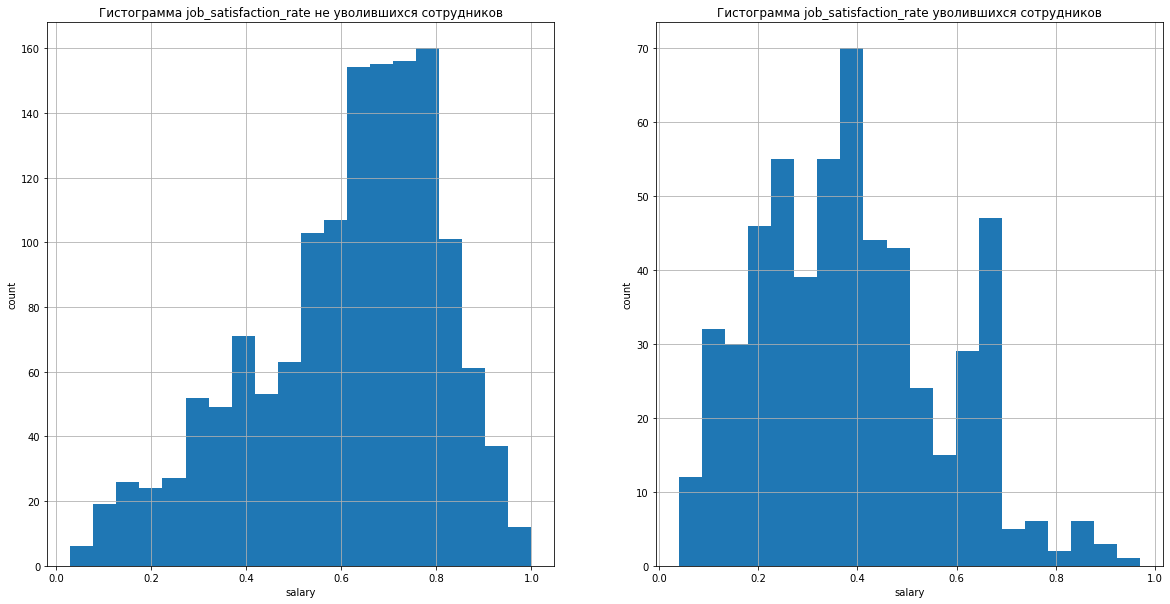

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
x = df_test_quit[df_test_quit['quit'] == 'no']['job_satisfaction_rate']
print('Статистики job_satisfaction_rate не уволившихся сотрудников')
print(x.describe())
print()
ax[0].hist(x, bins=20)
ax[0].set_xlabel(colum)
ax[0].set_ylabel('count')
ax[0].set_title('Гистограмма job_satisfaction_rate не уволившихся сотрудников')
ax[0].grid(True)

x = df_test_quit[df_test_quit['quit'] == 'yes']['job_satisfaction_rate']
print('Статистики job_satisfaction_rate уволившихся сотрудников')
print(x.describe())
ax[1].hist(x, bins=20)
ax[1].set_xlabel(colum)
ax[1].set_ylabel('count')
ax[1].set_title('Гистограмма job_satisfaction_rate уволившихся сотрудников')
ax[1].grid(True)

Гистограммы напоминают нормальное распределение, скос распределения у не уволившихся сотрудников в сторону большего уровня удовлетворенности, у уволившихся сотрудников скос в обратном направлении. Среденее значение сильно отличается у не уволившихся сотрудников 0.61, у уволившихся сотрудников 0.38. В целом чем больше уровень удовлетворенности тем меньше вероятность увольнения сотрудника. Наблюдаем дисбаланс классов, не уволившихся сотрудников к уволившимся сотрудникам ~ 3 к 1

### Корреляционный анализ

Построим "хитмап" по матрице корреляций Фика, посмотрим на связь признаков с целевой переменной и для отслеживания мультиколлинеарности

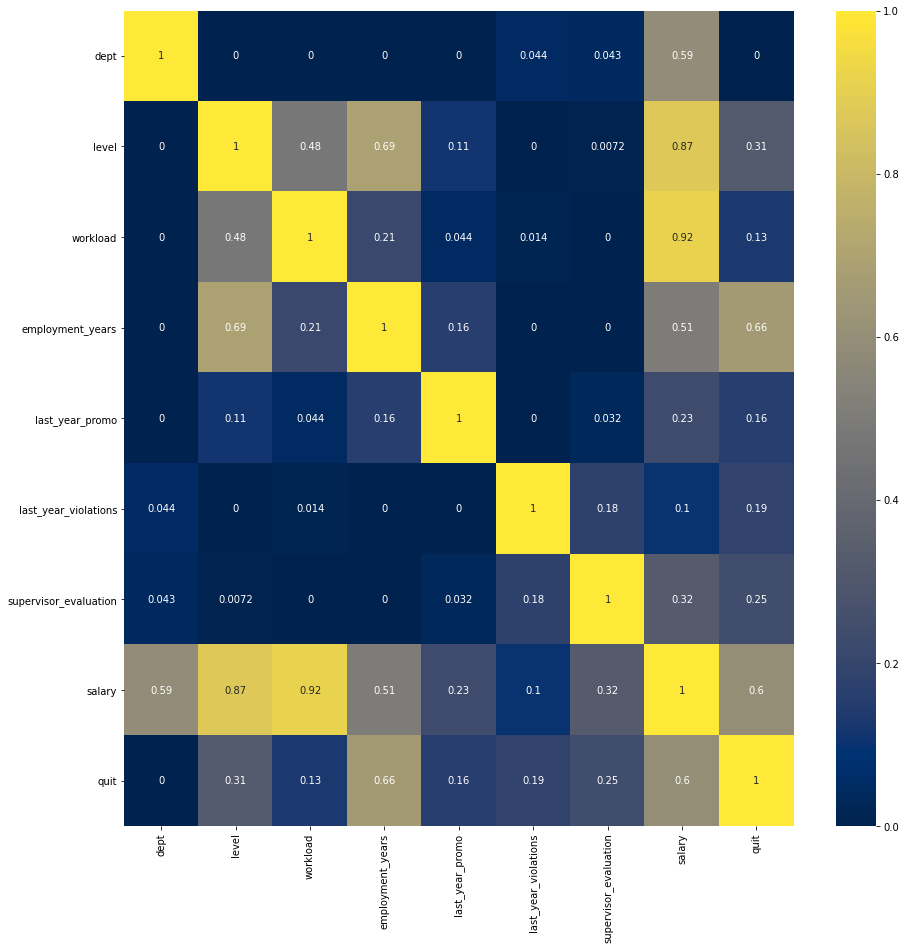

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df_train_quit[['dept', 'level', 'workload',
                           'employment_years', 'last_year_promo',
                           'last_year_violations', 'supervisor_evaluation',
                           'salary', 'quit']].phik_matrix(interval_cols = 'salary'
                                                         ),annot=True, cmap='cividis').legend = False

Наблюдаем высокую корреляцию между workload и salary, в далнейшем можно будет попробовать откинуть один из признаков для повышения качества модели

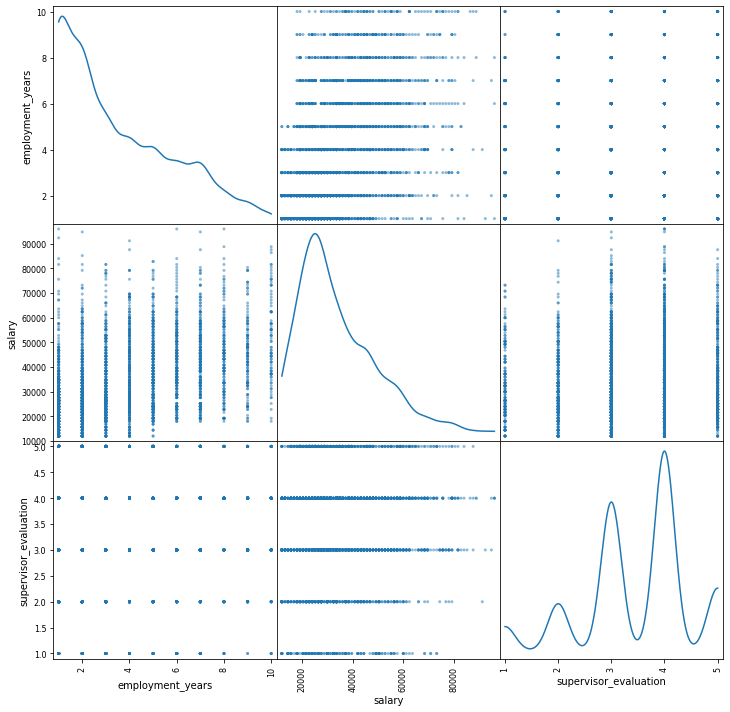

In [ ]:
corr_multi = df_train_quit.pivot_table(index='id', values=df_train_quit.columns[1:], aggfunc='mean')
sm = pd.plotting.scatter_matrix(corr_multi, figsize=(12, 12), diagonal='kde')

plt.show()

Корреляция целевого признака на кол-ые переменные описана в п.10

### Добавление нового входного признака

Добавим в обучающую выборку признак удовлетворенности используя предсказание обученной модели из прошлого задания

Получение предсказания удовлетворенности и добавление его в обучающий фрейм

In [ ]:
y_train_pred = randomized_search.best_estimator_.predict(df_train_quit.drop(['id', 'quit'], axis=1))

df_train_quit['job_satisfaction_rate'] = list(y_train_pred)
df_train_quit.head()

id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  \
0                   no                      4   54000   no   
1                   no                      4   27600   no   
2                   no                      1   37200   no   
3                  yes                      3   24000  yes   
4                   no                      5   25200   no   

   job_satisfaction_rate  
0               0.600000  
1               0.846364  
2               0.380000  
3               0.380000  
4               0.690000

Взглянем на индексы входных признаков тестовой выборки и на индексы целевого признака тестовой выборки из предыдущего задания

In [ ]:
y_train_pred = randomized_search.best_estimator_.predict(X_test_quit.drop(['id'], axis=1))

X_test_quit['job_satisfaction_rate'] = list(y_train_pred)
X_test_quit.head()

id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      5   28800               0.866667  
1                   no                      4   30000               0.681429  
2                   no                      4   19200               0.654000  
3                   no                      4   19200               0.655000  
4                   no                      5   40800               0.760000

### Подготовка данных

Выделим 'фичи' и целевую переменную из тренировочного фрейма

In [ ]:
X_train_quit = df_train_quit.drop(['id', 'quit'], axis=1)
X_train_quit.head()

dept   level workload  employment_years last_year_promo  \
0       sales  middle     high                 2              no   
1       sales  junior   medium                 2              no   
2  purchasing  middle   medium                 5              no   
3       sales  junior   medium                 2              no   
4   marketing  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      4   54000               0.600000  
1                   no                      4   27600               0.846364  
2                   no                      1   37200               0.380000  
3                  yes                      3   24000               0.380000  
4                   no                      5   25200               0.690000

In [ ]:
X_train_quit.duplicated().sum()

1545

Наблюдаем что после удаления 'id' и целевого признака появилось 1247 явных дубликата

Проверим сколько явных дубликатов будет если добавить к фрейму целевой признак

In [ ]:
df_train_quit_learn = df_train_quit.drop('id', axis=1)
df_train_quit_learn.head()

dept   level workload  employment_years last_year_promo  \
0       sales  middle     high                 2              no   
1       sales  junior   medium                 2              no   
2  purchasing  middle   medium                 5              no   
3       sales  junior   medium                 2              no   
4   marketing  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  \
0                   no                      4   54000   no   
1                   no                      4   27600   no   
2                   no                      1   37200   no   
3                  yes                      3   24000  yes   
4                   no                      5   25200   no   

   job_satisfaction_rate  
0               0.600000  
1               0.846364  
2               0.380000  
3               0.380000  
4               0.690000

In [ ]:
df_train_quit_learn.duplicated().sum()

1413

1413 явных дубликатов после удаления 'id' из выборки, их точно удалим

In [ ]:
X_train_quit.duplicated().sum() - df_train_quit_learn.duplicated().sum()

132

132 значений с одинаковыми входными признаками но разными результатами целевой переменной, их оставим

In [ ]:
df_train_quit_learn = df_train_quit_learn.drop_duplicates().reset_index(drop=True)
df_train_quit_learn.duplicated().sum()

0

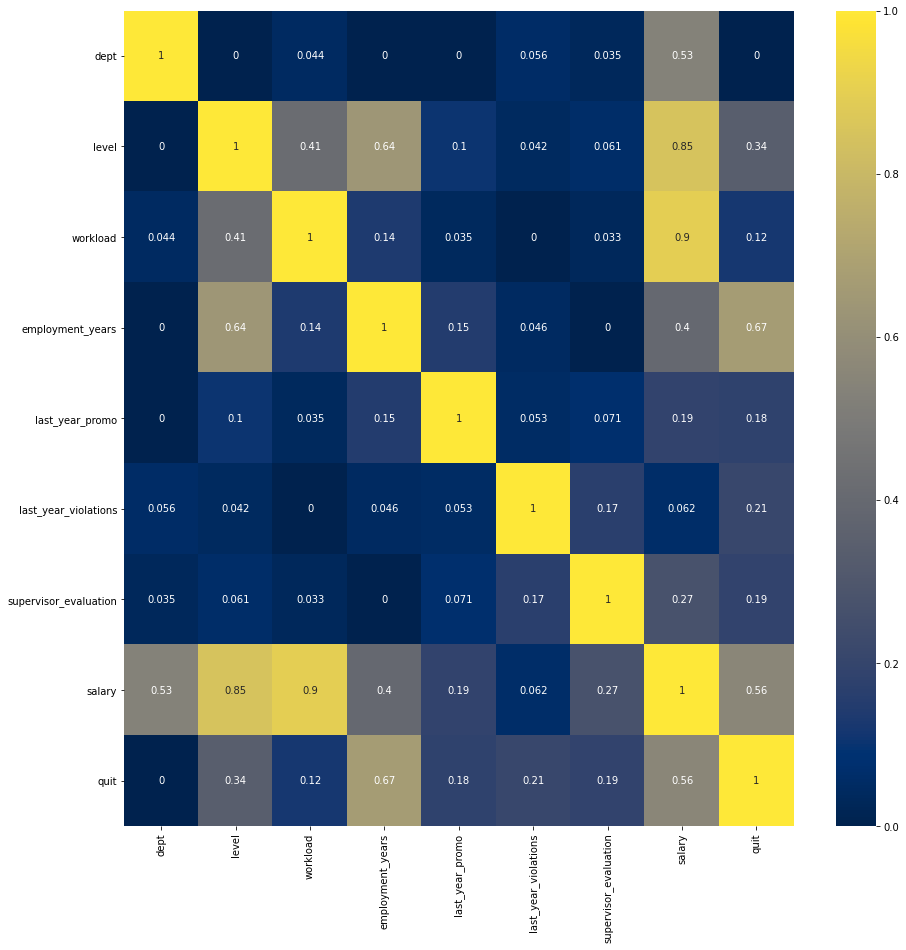

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df_train_quit_learn[['dept', 'level', 'workload',
                           'employment_years', 'last_year_promo',
                           'last_year_violations', 'supervisor_evaluation',
                           'salary', 'quit']].phik_matrix(interval_cols = 'salary'
                                                         ),annot=True, cmap='cividis').legend = False

Высокая корреляцию между workload и salary осталась, хоть и стала меньше

In [ ]:
X_train_quit = df_train_quit_learn.drop('quit', axis=1)
X_train_quit.head()

dept   level workload  employment_years last_year_promo  \
0       sales  middle     high                 2              no   
1       sales  junior   medium                 2              no   
2  purchasing  middle   medium                 5              no   
3       sales  junior   medium                 2              no   
4   marketing  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      4   54000               0.600000  
1                   no                      4   27600               0.846364  
2                   no                      1   37200               0.380000  
3                  yes                      3   24000               0.380000  
4                   no                      5   25200               0.690000

Закодируем целевой признак LabelEncoder

In [ ]:
y_train_quit = df_train_quit_learn['quit']
y_train_quit.head()

0     no
1     no
2     no
3    yes
4     no
Name: quit, dtype: object

In [ ]:
le = LabelEncoder()
y_train_quit = pd.Series(le.fit_transform(y_train_quit))
y_train_quit.head()

0    0
1    0
2    0
3    1
4    0
dtype: int64

In [ ]:
y_test_quit.head()

id quit
0  485046   no
1  686555   no
2  467458   no
3  418655   no
4  789145   no

In [ ]:
y_test_quit = pd.Series(le.transform(y_test_quit['quit']))
y_test_quit.head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

Струтура готового пайплайна у нас уже есть из прошлого задания, осталось добавить только в список кол-ых входных признаков job_satisfaction_rate

In [ ]:
num_columns = ['salary', 'job_satisfaction_rate']

In [ ]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=42))
])

In [ ]:
pipe_final

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'senior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('num', MinMaxScaler(),
                                                  ['salary',
                                                   'job_satisfaction_rate'])])),
                ('models', LogisticRegression(random_state=42))])

Задаем параметры для кросс-валидации и перебора моделей с гиперпараметрами

In [ ]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=42)],
        'models__max_depth': range(2, 31, 2),
        'models__max_features': range(2, 13, 2),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 200, 5),
        'models__metric': ['euclidean', 'cityblocks'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=42)],
        'models__C': [0.01, 0.1, 1, 10],
        'models__penalty': ['l1', 'l2', 'elasticnet', 'None'],
        'models__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели SVC()
    {
        'models': [SVC(random_state=42, probability=True)],
        'models__kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
        'models__C': [0.01, 0.1, 1, 10],
        'models__degree': range(1, 5),
        'models__gamma': ['scale', 'auto'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

### Обучение моделей

#### Базовая модель

Методом RandomizedSearchCV запускаем перебор моделей и их гиперпараметров на метрике ROC-AUC

In [ ]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)

randomized_search.fit(X_train_quit, y_train_quit)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

Лучшей моделью на кросс-валидации получилась SVC(C=10, degree=4) с масштабированием MinMaxScaler() кол-ых признаков.

In [ ]:
y_test_pred = randomized_search.predict_proba(X_test_quit.drop('id', axis=1))
y_test_pred = y_test_pred[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_quit, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.9216172534028725


Наблюдаем результат на тесте равный 0.921, что проходит по нашему критерию успеха. В качестве доп задания, рассмотрим методы ансамблирования, обучим нейросеть, избавимся от дисбаланса класса и посмотрим какого результата удастся добиться

#### Дисбаланс классов

Попробуем решить проблему дисбаланса классов методами Oversampling

In [ ]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

sampler = ColumnTransformer(SMOTENC(random_state=42, k_neighbors=5,
                                    categorical_features=ohe_columns+ord_columns), remainder='passthrough')
over = SMOTE(sampling_strategy=0.1)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('over', over),
    ('models', RandomForestClassifier(random_state=42))
])

In [ ]:
param_grid = [
    # словарь для модели RandomForestClassifier()
    {
        'models': [RandomForestClassifier(random_state=42)],
        'models__min_samples_leaf': range(1, 20),
        'models__max_depth': range(2, 30),
        'models__min_samples_split': range(2, 20),
        'models__max_features': range(2, 13),
        'models__n_estimators': range(10, 101),
        'models__criterion': ['gini', 'entropy', 'log_loss'],
    }
]

In [ ]:
 pipe_final

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',...
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'senior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('num', MinMaxScaler(),
                                                  ['salary',
                                                   'job_satisfaction_rate'])])),
                ('over', SMOTE(sampling_strategy=0.1)),
                ('models', RandomForestClassifier(random_state=42))])

In [ ]:
# randomized_search = RandomizedSearchCV(
#     pipe_final,
#     param_grid,
#     cv=5,
#     n_iter=20,
#     scoring='roc_auc',
#     random_state=42,
#     n_jobs=-1
# )

# randomized_search.fit(X_train_quit, y_train_quit)
# print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
# print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)


#### Методы ансамблирования

Обучим ансамблевый алгоритм бэггинга RandomForestClassifier

In [ ]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', RandomForestClassifier(random_state=42))
])

param_grid = [
    # словарь для модели RandomForestClassifier()
    {
        'models': [RandomForestClassifier(random_state=42)],
        'models__min_samples_leaf': range(1, 20),
        'models__max_depth': range(2, 30),
        'models__min_samples_split': range(2, 20),
        'models__max_features': range(2, 13),
        'models__n_estimators': range(10, 101),
        'models__criterion': ['gini', 'entropy', 'log_loss'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

randomized_search_rf = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)

randomized_search_rf.fit(X_train_quit, y_train_quit)
print('Лучшая модель и её параметры:\n\n', randomized_search_rf.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search_rf.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

Код для перебора гиперпараметров MLPClassifier, т.к. модель сильно переобучается search бы не потобрал оптимальных параметров. Сделал перебор случайного зерна(500 итераций) для search (в randomized_search одна итерация) в котором случайно подбирались гиперпараметры(оставлял на ночь)

In [ ]:
# for i in range(1, 501):
#     model = MLPClassifier(random_state=RANDOM_STATE, hidden_layer_sizes=(7, 7))

#     parameters = {
#         'alpha': [0.0001, 0.0005 ,0.001, 0.005, 0.01, 0.05, 0.1,  0.5, 1],
#         'activation': ['relu', 'tanh', 'logistic'],
#         'solver': ['lbfgs', 'sgd', 'adam'],
#         'learning_rate_init': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
#     }

#     randomized_search = RandomizedSearchCV(
#         model,
#         parameters,
#         cv=5,
#         n_iter=1,
#         scoring='roc_auc',
#         random_state=i,
#         n_jobs=-1
#     )
#     randomized_search.fit(X_train_res_, y_train_res_)

#     y_valid_pred = randomized_search.predict(X_valid_)
#     y_valid_bi = y_valid.apply(lambda x: 0 if x == 'no' else 1)
#     y_valid_pred_bi = pd.Series(y_valid_pred).apply(lambda x: 0 if x == 'no' else 1)

#     y_test_pred = randomized_search.predict(X_test_quit_)
#     y_test_bi = y_test_quit_.apply(lambda x: 0 if x == 'no' else 1)
#     y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'no' else 1)

#     if roc_auc_score(y_test_bi, y_test_pred_bi) > 0.9:
#         print(i)
#         print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
#         print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
#         print(f'Метрика ROC-AUC на валидационной выборке: {roc_auc_score(y_valid_bi, y_valid_pred_bi)}')
#         print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

Лучшей моделью получилась MLPClassifier(activation='tanh', alpha=0.5, hidden_layer_sizes=(7, 7),
              learning_rate_init=0.1, random_state=42, solver='lbfgs')

In [ ]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', MLPClassifier(
    alpha=0.5, learning_rate_init=0.1, activation='tanh', solver="lbfgs", hidden_layer_sizes=(7, 7), random_state=42
))
])

param_grid = [
    {
        'preprocessor__num': [MinMaxScaler()]
    }
]

randomized_search_nn = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    n_iter=1,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)

randomized_search_nn.fit(X_train_quit, y_train_quit)
print('Лучшая модель и её параметры:\n\n', randomized_search_nn.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search_nn.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

Обучим ансамблевый алгоритм бустинга CatBoostClassifier

Подберем learning_rate для нахождения минимума функции ошибки

In [ ]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', CatBoostClassifier(
        iterations=500,
        random_seed=42,
        use_best_model=True
        ))
])

param_grid = [
    # словарь для модели CatBoostClassifier()
    {
        'models': [CatBoostClassifier(iterations=500,
        random_seed=42,
        use_best_model=True)],
        'models__learning_rate': [i/100 for i in range(1, 11)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

randomized_search_cat = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    n_iter=10,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)

randomized_search_cat.fit(X_train_quit, y_train_quit, models__verbose=False,
                          models__eval_set=(data_preprocessor.fit_transform(X_test_quit.drop('id', axis=1)), y_test_quit))
print('Лучшая модель и её параметры:\n\n', randomized_search_cat.best_estimator_.get_params())
print ('Метрика лучшей модели на кросс-валидации:', randomized_search_cat.best_score_)

Лучшая модель и её параметры:

 {'memory': None, 'steps': [('preprocessor', ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['dept', 'last_year_promo',
                                  'last_year_violations']),
                                ('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='most_frequent')),
                                         

learning_rate = 0.01 c масштабированием кол-ых признеков StandardScaler() являются оптимальными параметрами CatBoostClassifier

In [ ]:
y_test_pred_bi_cat = randomized_search_cat.predict_proba(X_test_quit.drop('id', axis=1))
y_test_pred_bi_cat = y_test_pred_bi_cat[:,1]

y_test_pred_bi_nn = randomized_search_nn.predict_proba(X_test_quit.drop('id', axis=1))
y_test_pred_bi_nn = y_test_pred_bi_nn[:,1]

y_test_pred_bi_rf = randomized_search_rf.predict_proba(X_test_quit.drop('id', axis=1))
y_test_pred_bi_rf = y_test_pred_bi_rf[:,1]

print(f'Метрика ROC-AUC CatBoost на тестовой выборке: {roc_auc_score(y_test_quit, y_test_pred_bi_cat)}')
print()

print(f'Метрика ROC-AUC нейросети на тестовой выборке: {roc_auc_score(y_test_quit, y_test_pred_bi_nn)}')
print()

print(f'Метрика ROC-AUC случайного леса на тестовой выборке: {roc_auc_score(y_test_quit, y_test_pred_bi_rf)}')
print()

Метрика ROC-AUC CatBoost на тестовой выборке: 0.9289391088326517

Метрика ROC-AUC нейросети на тестовой выборке: 0.9259128242359588

Метрика ROC-AUC случайного леса на тестовой выборке: 0.9259276408068116



Попробуем получить meta-модель которая будет включать голоса предсказаний CatBoost, нейросети и случайного леса. Вес голосов подберем из наилучшего результата метрики ROC-AUC

In [ ]:
l = []
p = []
for i in [j/100 for j in range(50, 250)]:

    meta_test = pd.concat([pd.Series(y_test_pred_bi_rf), pd.Series(y_test_pred_bi_cat), pd.Series(y_test_pred_bi_nn)], axis=1)
    meta_test['meta'] = meta_test[0]+meta_test[1]+meta_test[2]
    meta_test['meta_pred'] = meta_test['meta'].apply(lambda x: 1 if x > i else 0)
    meta_test = meta_test['meta_pred']
    l.append(roc_auc_score(y_test_quit, meta_test))
    p.append(i)

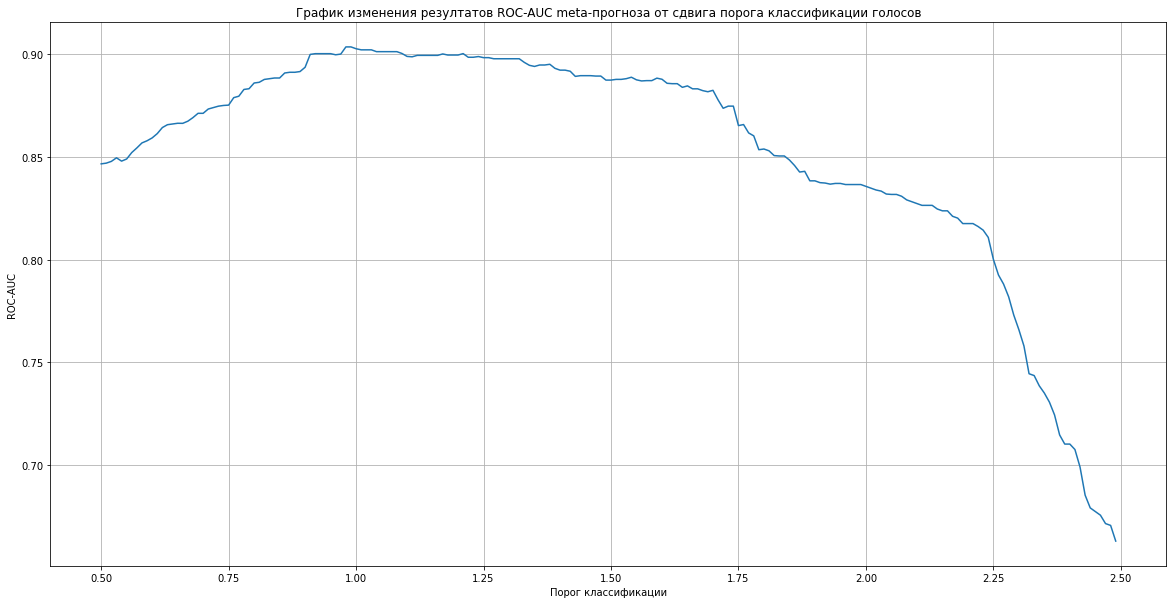

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

plt.plot(p, l)
plt.title('График изменения резултатов ROC-AUC meta-прогноза от сдвига порога классификации голосов')
plt.xlabel('Порог классификации')
plt.ylabel('ROC-AUC')
plt.grid(True)
plt.show()

In [ ]:
max(l)

0.9035070823208677

Лучшим результатом на тестовых данных показал алгоритм CatBoost: ROC-AUC = 0.928 что проходит по нашему критерию

### Промежуточный вывод о модели

Был проведен перебор моделей и их гиперпараметров(DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression, SVC) с предобработкой данных в пайплайне с разными методами масштабирования(StandardScaler, MinMaxScaler, 'passthrough') при помощи RandomizedSearchCV на метрике ROC-AUC. Лучшей моделью на кросс-валидации получилась модель SVC(C=10, degree=4) с масштабированием MinMaxScaler() кол-ых признаков и метрикой ROC-AUC равной 0.921 на тестовой выборке.

Обучен ансамблевый алгоритм бэггинга RandomForestClassifier, метрика ROC-AUC на кросс-валидации: 0.9170484635885598

Обучен алгоритм многослойного перцептрона (MLP), который обучается с использованием обратного распространения (нейросеть). В качестве параметров по умолчанию взяты 7 слоев с глубиной в 7 нейронов, метрика ROC-AUC на кросс-валидации: 0.857

Подобранны лучшие гиперпараметры нейросети MLPClassifier(activation='tanh', alpha=0.5, hidden_layer_sizes=(10, 10), learning_rate_init=1, random_state=42, solver='lbfgs'), метрика ROC-AUC на на кросс-валидации: 0.914

Обучен ансамблевый алгоритм бустинга CatBoostClassifier, метрика ROC-AUC на тестовой выборке: 0.908

Подобран оптимальный learning_rate для нахождения минимума функции ошибки CatBoostClassifier, лучшие гиперпараметры: CatBoostClassifier(iterations=500, learning_rate = 0.05, random_seed=42, use_best_model=True), метрика ROC-AUC на тестовой выборке: 0.927

Получен meta-прогнос с учетом голосов CatBoost, случайного леса и нейросети: метрика ROC-AUC на валидационной выборке: 0.875, метрика ROC-AUC на тестовой выборке: 0.901

Произведена проверка моделей CatBoost, случайного леса и нейросети на тестовых данных и полученны результаты:

Метрика ROC-AUC CatBoost на тестовой выборке: 0.9278649074458206

Метрика ROC-AUC нейросети на тестовой выборке: 0.9259128242359588

Метрика ROC-AUC случайного леса на тестовой выборке: 0.9259276408068116

Лучшим оказался ансамблевый алгоритм бустинга CatBoostClassifier, его и рекомендуем использовать в продакшене

### Общий вывод

В проделанной работе есть промежуточные выводы, в общем выводе я бы хотел обобщить их и подвести итог по работе с данными

**Задача 1: предсказание уровня удовлетворённости сотрудника**

<h4>Загрузка данных</h4>

**Данные представленны в 3 файлах:**

-В первой таблице 5 колонок типа object: dept, level, workload, last_year_promo, last_year_violations;

4 колонки типа int: id, employment_years, supervisor_evaluation, salary;

1 колонка типа float: job_satisfaction_rate;

-Во второй таблице колонки идентичны 1-ой таблице за исключением целевого признака job_satisfaction_rate

-В третьей таблице колонка типа int (id) и целевой признак типа float: job_satisfaction_rate

<h4>Предобработка данных</h4>

Типы данных в фреймах представленны корректно

Была проведена проверка на наличе пропусков в данных, пропусков не обнаружилось

Явных дубликатов в данных не обнаружилось

Была проведена работа по приведению значений ' ' к nan категориальных переменных workload, dept фрейма X_test_rate, дубликатов не появилось

Был приведен порядок id у целевого признака тестовых данных в соответствие id входных признаков

<h4>Исследовательский анализ данных(train)</h4>

Проведено исследование **категориальных признаков:**

-Значения 'dept'( отдела, в котором работает сотрудник) делятся на 5 частей, чаще всего встречается отдел 'sales'(37.9%), по убыванию: 'technology'(21.7%), 'purchasing'(15.3%), 'marketing'(13.8%), hr(11.4%)

-Значения 'level'(уровень занимаемой должности) делятся на 3 частей, чаще всего встречается уровень 'junior'(47.4%), 'middle'(43.6%), реже всего встречается 'sinior'(9%)

-Значения 'workload'(уровень загруженности сотрудника) делятся на 3 частей, чаще всего встречается уровень 'medium'(51.6%), 'low'(30%), реже всего встречается 'high'(18.4%)

-Значения 'last_year_promo'(было ли повышение за последний год) делятся на 2 части, чаще всего встречается знаяение 'no'(97%), реже встречается 'yes'(3%)

-Значения 'last_year_violations'(нарушал ли сотрудник трудовой договор за последний год) делятся на 2 части, чаще всего встречается знаяение 'no'(86%), реже встречается 'yes'(14%)

Исследование **кол-ых признаков:**

Выделенны категории из целевого признака, для цветовой маркировки на гистограммах

-'employment_years'(длительность работы в компании) напоминает распределение Пуасона со 'скосом' к левому краю разброс длительности варьируется от 1 до 10 лет, в среднем 3.71

Цветовой маркер целевого признака указывает что уровень удовлетворённости сотрудника работой в компании меньше у людей которые меньше проработали

Аномальных значений не наблюдаем

-'supervisor_evaluation'(оценка качества работы сотрудника, которую дал руководитель) напоминает распределение Пуасона со 'скосом' к правому краю разброс оценки варьируется от 1 до 5, в среднем 3.47

Уровень удовлетворённости больше у сотрудников оцененных 4 или 5

'1' является слегка выбивающимся значением от общей массы

-'salary'(ежемесячная зарплата сотрудника) напоминает нормальное распределение со 'скосом' к левому краю разброс зарплаты варьируется от 12000 до 98400, в среднем 33926

Уровень удовлетворённости идентичный на почти всех уровнях зарплаты, только у слегка выбивающихся значений по правому краю уровень выше

Значения находящиеся в правой части распределения слегка выбиваются из общей массы

-'job_satisfaction_rate'(уровень удовлетворённости сотрудника работой в компании, целевой признак) напоминает нормальное распределение разброс уровня варьируется от 0.03 до 1, в среднем 0.53

Аномальных значений не наблюдаем

<h4>Исследовательский анализ данных (test)</h4>

Проведено исследование **категориальных признаков:**

-Отличия на test значений 'dept': 'sales'(38.2%), 'technology'(22.8%), 'purchasing'(13.7%), 'marketing'(14%), hr-идентичная доля(11.4%)

-Отличия на test значений 'level': 'junior'(48.7%), 'middle'(42.7%), 'sinior'(8.6%)

-Отличия на test значений 'workload': 'medium'(52.2%), 'low'(29.7%), 'high'(18.2%)

-Отличия на test значений 'last_year_promo': 'no'(96.8%), 'yes'(3.2%)

-Отличия на test значений 'last_year_violations': 'no'(86.9%),  'yes'(13.1%)

Исследование **кол-ых признаков:**

**'employment_years'**

-Отличия на test: распределение идентично, разброс тот же, среднее значение сместилось 3.66. Закономерности маркера целевого признака не изманились. Аномалий нет

**'supervisor_evaluation'**

-Отличия на test: распределение идентично, разброс тот же, среднее значение сместилось 3.52. Закономерности маркера целевого признака не изманились. '1' так же слегка выбивающиеся значение из общей массы

**'salary'**

-Отличия на test: распределение идентично, максимальное значение зарплаты сместилось в чуть меньшую сторону 96000, среднее значение слегка сместилось 34066. Закономерности маркера целевого признака не изманились. Идентичные значения находящиеся в правой части распределения слегка выбивающиеся из общей массы

-**'job_satisfaction_rate'**

-Отличия на test: распределение смещенно вправо напоминает нормальное, разброс тот же, среднее значение слегка сместилось 0.54. Аномалий нет

<h4>Корреляционный анализ(train)</h4>

Построен "хитмап" по матрице корреляций Фика, для отслеживания связи признаков с целевой переменной и для отслеживания мультиколлинеарности, мультиколлинеарности в данных не прослеживается

Построенны scatter графики кол-ых признаков относительно целевого, с цветовым маркером категориальных переменных:

-employment_years(длительность работы в компании) относительно rate:

уровень удовлетворённости сотрудника работой в компании меньше у людей которые меньше проработали

цветовой маркер dept(отдел, в котором работает сотрудник) случаен

цветовой маркер level(уровень занимаемой должности) наблюдаем что чем дольше сотрудник работает тем выше занимаемая должность

цветовой маркер workload(уровень загруженности сотрудника) случаен

-supervisor_evaluation(оценка качества работы сотрудника, которую дал руководитель) относительно rate:

уровень удовлетворённости выше у сотрудников оцененных на 4 или 5

цветовой маркер dept(отдел, в котором работает сотрудник) случаен

цветовой маркер level(уровень занимаемой должности) случаен

цветовой маркер workload(уровень загруженности сотрудника) случаен

-salary(ежемесячная зарплата сотрудника) относительно rate:

уровень удовлетворённости идентичный на почти всех уровнях зарплаты, свыше 60000 кластер слегка смещается в сторону повышенной удовлетворенности

цветовой маркер dept(отдел, в котором работает сотрудник) случаен

цветовой маркер level(уровень занимаемой должности) наблюдаем что чем больше у сотрудника зарплата тем выше занимаемая должность

цветовой маркер workload(уровень загруженности сотрудника) чем выше у сотрудника загруженность тем выше у него зарплата

<h4>Корреляционный анализ(test)</h4>

Построен "хитмап" по матрице корреляций Фика, для отслеживания связи признаков с целевой переменной и для отслеживания мультиколлинеарности, мультиколлинеарности в данных не прослеживается

Патерн цветового маркера категориальных переменных на scatter целевого признака и кол-ых переменных идентичный train выборке


<h4>Вывод о модели</h4>

Был проведен перебор моделей и их гиперпараметров(DecisionTreeRegressor, Ridge, ElasticNet, LinearRegression) с предобработкой данных в пайплайне с разными методами масштабирования(StandardScaler, MinMaxScaler, 'passthrough') при помощи RandomizedSearchCV на пользовательской метрике SMAPE(подсчет сохранен в функции get_smape).  Лучшей моделью на кросс-валидации получилась модель DecisionTreeRegressor(max_features=10, random_state=42) с масштабированием кол-ых признаков StandardScaler()

Метрика smape на кросс-валидации: 15.949729247686468 с стандартным отклонением: 0.464085253927581

Метрика на тестовой выборке: 14.820731870750024

Построенна константная модель DummyRegressor для проверки лучшей модели на адекватность:

Метрика на тестовой выборке: 38.26225790202237

**Задача 2: предсказание увольнения сотрудника из компании**

<h4>Загрузка данных</h4>

**Данные представленны в 3 файлах:**

-В первой таблице 6 колонок типа object: dept, level, workload, last_year_promo, last_year_violations, quit;

4 колонки типа int: id, employment_years, supervisor_evaluation, salary;

-Во второй таблице колонки идентичны 1-ой таблице за исключением целевого признака quit

-В третьей таблице колонка типа int (id) и целевой признак типа object: quit

<h4>Предобработка данных</h4>

Типы данных в фреймах представленны корректно

Была проведена проверка на наличе пропусков в данных, пропусков не обнаружилось

Явных дубликатов в данных не обнаружилось

Была проведена работа по приведению значений ' ' к nan категориальных переменных workload, dept фрейма X_test_quit, дубликатов не появилось

Был приведен порядок id у целевого признака тестовых данных в соответствие id входных признаков

<h4>Исследовательский анализ данных</h4>

Проведено исследование **категориальных признаков:**

-Значения 'dept'( отдела, в котором работает сотрудник) делятся на 5 частей, чаще всего встречается отдел 'sales'(36%), по убыванию: 'technology'(23.2%), 'marketing'(14.6%), 'purchasing'(14.7%), hr(11.6%)

-Значения 'level'(уровень занимаемой должности) делятся на 3 частей, чаще всего встречается уровень 'junior'(48.7%), 'middle'(42.3%), реже всего встречается 'sinior'(8.9%)

-Значения 'workload'(уровень загруженности сотрудника) делятся на 3 частей, чаще всего встречается уровень 'medium'(53%), 'low'(30.2%), реже всего встречается 'high'(16.9%)

-Значения 'last_year_promo'(было ли повышение за последний год) делятся на 2 части, чаще всего встречается знаяение 'no'(97.2%), реже встречается 'yes'(2.8%)

-Значения 'last_year_violations'(нарушал ли сотрудник трудовой договор за последний год) делятся на 2 части, чаще всего встречается знаяение 'no'(86.4%), реже встречается 'yes'(13.6%)

Исследование **кол-ых признаков:**

Цветовым маркером на гистограммах обозначен целевой признак

-**'employment_years'**(длительность работы в компании) напоминает распределение Пуасона  со 'скосом' к левому краю разброс длительности варьируется от 1 до 10 лет, в среднем 3.7

Уровень удовлетворённости сотрудника работой в компании меньше у людей которые меньше проработали. Цветовой маркер увольнения сотрудника из компании указывает что вероятность увольнения сотрудника меньше у людей которые больше проработали

Аномальных значений не наблюдаем

-**'supervisor_evaluation'**(оценка качества работы сотрудника, которую дал руководитель) напоминает распределение Пуасона со 'скосом' к правому краю разброс оценки варьируется от 1 до 5, в среднем 3.47

Уровень удовлетворённости больше у сотрудников оцененных 4 или 5. Цветовой маркер увольнения указывает что вероятность уволнения меньше у сотрудников с оценкой 4 и 5

'1' является слегка выбивающимся значением от общей массы

-**'salary'**(ежемесячная зарплата сотрудника) напоминает нормальное распределение со 'скосом' к левому краю разброс зарплаты варьируется от 12000 до 96000, в среднем 33805

Уровень удовлетворённости идентичный на почти всех уровнях зарплаты, только у слегка выбивающихся значений по правому краю уровень выше. Цветовой маркер указывает что чем выше зарплата тем меньше вероятность увольнения

Значения находящиеся в правой части распределения слегка выбиваются из общей массы

-**Резюмируя уровень удовлетворённости относительно маркера увольнения** чем больше уровень удовлетворенности тем меньше вероятность увольнения сотрудника

Рассмотренно влияние уровеня удовлетворенности в разрезе увольнения сотрудника на тестовой выборке:

Гистограммы напоминают нормальное распределение, скос распределения у не уволившихся сотрудников в сторону большего уровня удовлетворенности, у уволившихся сотрудников скос в обратном направлении. Среденее значение сильно отличается у не уволившихся сотрудников 0.61, у уволившихся сотрудников 0.38. В целом чем больше уровень удовлетворенности тем меньше вероятность увольнения сотрудника. Наблюдаем дисбаланс классов, не уволившихся сотрудников к уволившимся сотрудникам ~ 3 к 1

<h4>Корреляционный анализ</h4>

Построен "хитмап" по матрице корреляций Фика, для отслеживания связи признаков с целевой переменной и для отслеживания мультиколлинеарности, наблюдаем высокую корреляцию между workload и salary

<h4>Добавление нового входного признака</h4>

Добавленно в обучающую выборку признак удовлетворенности используя предсказание обученной модели из прошлого задания

<h4>Вывод о модели</h4>

Был проведен перебор моделей и их гиперпараметров(DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression, SVC) с предобработкой данных в пайплайне с разными методами масштабирования(StandardScaler, MinMaxScaler, 'passthrough') при помощи RandomizedSearchCV на метрике ROC-AUC. Лучшей моделью на кросс-валидации получилась модель SVC(C=10, degree=4) с масштабированием MinMaxScaler() кол-ых признаков и метрикой ROC-AUC равной 0.921 на тестовой выборке.

Обучен ансамблевый алгоритм бэггинга RandomForestClassifier, метрика ROC-AUC на кросс-валидации: 0.9170484635885598

Обучен алгоритм многослойного перцептрона (MLP), который обучается с использованием обратного распространения (нейросеть). В качестве параметров по умолчанию взяты 7 слоев с глубиной в 7 нейронов, метрика ROC-AUC на кросс-валидации: 0.857

Подобранны лучшие гиперпараметры нейросети MLPClassifier(activation='tanh', alpha=0.5, hidden_layer_sizes=(7, 7), learning_rate_init=1, random_state=42, solver='lbfgs'), метрика ROC-AUC на на кросс-валидации: 0.914

Обучен ансамблевый алгоритм бустинга CatBoostClassifier, метрика ROC-AUC на тестовой выборке: 0.908

Подобран оптимальный learning_rate для нахождения минимума функции ошибки CatBoostClassifier, лучшие гиперпараметры: CatBoostClassifier(iterations=500, learning_rate = 0.05, random_seed=42, use_best_model=True), метрика ROC-AUC на тестовой выборке: 0.927

Получен meta-прогнос с учетом голосов CatBoost, случайного леса и нейросети: метрика ROC-AUC на валидационной выборке: 0.875, метрика ROC-AUC на тестовой выборке: 0.901

Произведена проверка моделей CatBoost, случайного леса и нейросети на тестовых данных и полученны результаты:

Метрика ROC-AUC CatBoost на тестовой выборке: 0.9278649074458206

Метрика ROC-AUC нейросети на тестовой выборке: 0.9259128242359588

Метрика ROC-AUC случайного леса на тестовой выборке: 0.9259276408068116

Лучшим оказался ансамблевый алгоритм бустинга CatBoostClassifier, его и рекомендуем использовать в продакшене

**Рекомендации по снижению уровня увольнений**

Учитывая влияние уровеня удовлетворенности в разрезе увольнения сотрудника и важность признаков для модели, для снижения уровня увольнений необходимо:

-следить за качеством работы сотрудника и стремится к его повышению

-повышать уровень занимаемой должности

-повышать уровень заработной платы

-понижать уровень загруженности сотрудника

-следить за нарушениями трудового договора и стремиться к их минимизации